## Linear and Polynomial Regression for Skyrmion trajectories prediction

**Imports**

In [9]:
# Standard imports
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import random
import trackpy as tp
from tqdm import tqdm  # for progress bar

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, LinearRegression

# import functions
from my_functions import *

**Read data**

In [10]:
directory = '../'
data = pd.read_csv(directory + '/data/processed/trajectories.csv')
data = data.drop(data.columns[0], axis=1)
no_skyrmions = data[data['frame'] == 0].shape[0]

## Experiment 1: Predict next frame given one frame

In the first experiment we are trying to use Linear and Poly Regression to predict one frame in the future given the previous frame.

We will be considering all the frames for this experiment. The last 20% of the frames will be used a testing data whilst the rest is used as trainig data.

**Particles used for training**


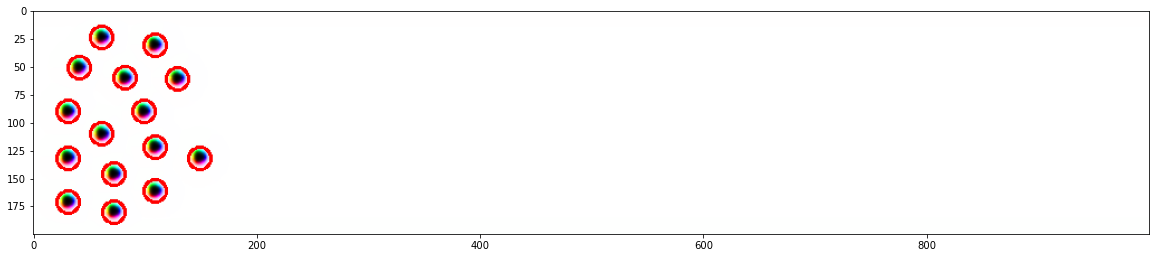

Getting frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:06<00:00, 119.59it/s]


In [12]:
# copy of data so that the original is unchanged
data_1 = data.copy()

# show which frames we will be working on
print('**Particles used for training**')
show_tracked(data_1, directory + '/data/raw/')

# format data so that it is in the format (frame, next_frame)
frames = get_frames(data_1)

# data in columns ['frame', 'next_frame']
df = pd.DataFrame(columns=['frame', 'next_frame'])

for i in range(1, len(frames)):
    df = df.append({'frame': frames[i-1], 'next_frame': frames[i]}, ignore_index=True)

**Linear Regression**

In [22]:
# split data in training and testing
X_train, y_train, X_test, y_test = split(df, 0.2)

# fit linear regression
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

# evaluate linear regression
print('The model performance for X_train')
y_predict_train = evaluate(X_train, y_train, lin_model)

print('The model performance for X_test')
y_predict_test = evaluate(X_test, y_test, lin_model)

The model performance for X_train
--------------------------------------
RMSE is 3.416191282758604
R2 score is 0.9854093671582872


The model performance for X_test
--------------------------------------
RMSE is 5.964209454235747
R2 score is 0.8295229850253383




In [23]:
y_predict_train.shape

(640, 30)

In [24]:
# prediction to dataframe
train_predict_df = get_predictions_df(y_predict_train)
test_predict_df = get_predictions_df(y_predict_test)

Prediction to dataframe: 100%|█████████████████████████████████████████████████████████████████████████████████████| 159/159 [00:02<00:00, 58.11it/s]


In [25]:
train_predict_df

,x,y,frame,particle
0,73.233952,23.119952,0.0,0.0
1,119.960174,31.080689,0.0,1.0
2,52.852041,54.181602,0.0,2.0
3,94.796791,62.798555,0.0,3.0
4,140.750924,62.088202,0.0,4.0
...,...,...,...,...
9595,7306.724256,66.236976,639.0,10.0
9596,7121.195528,27.877892,639.0,11.0
9597,7071.984747,160.629921,639.0,12.0
9598,6855.117638,136.304021,639.0,13.0


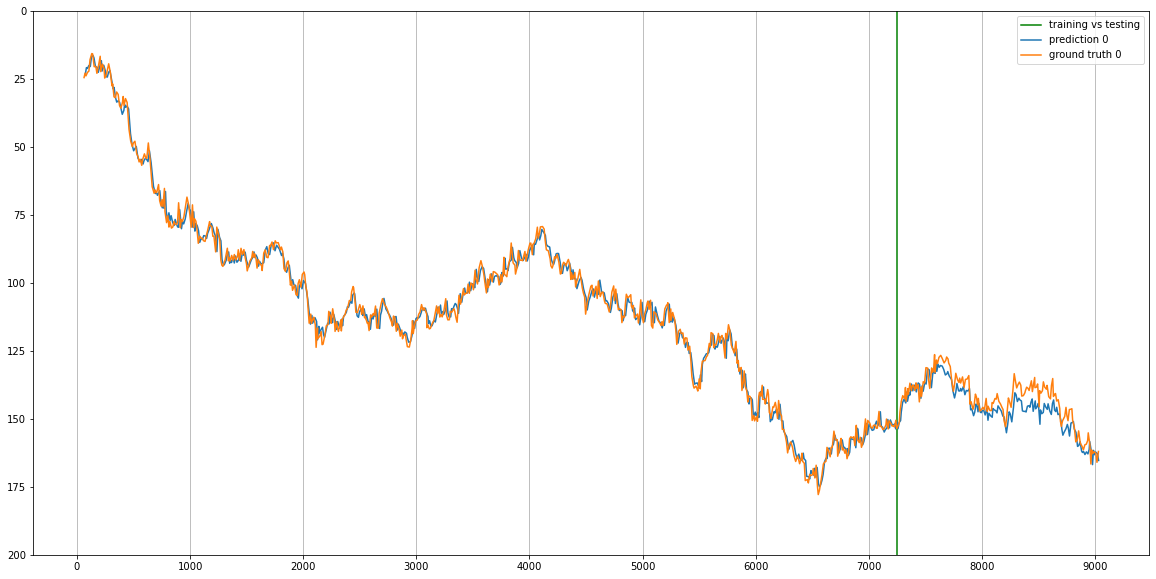

In [26]:
# plot prediction vs truth
plot_prediction(data_1, test_predict_df, train_predict_df, ids=[0])

**Poly Regression**

In [18]:
# pipeline for poly regression
# StandardScaler: Standardize features by removing the mean and scaling to unit variance
# PolynomialFeatures: specify the degree of the polynomial we want to fit the data
# Ridge: use ridge regression (regularization)
steps = [
    ('scalar', StandardScaler()),
    ('poly', PolynomialFeatures(degree=1)),
    ('model', Ridge(alpha=0.5, fit_intercept=True))
]

pipeline = Pipeline(steps)

pipeline.fit(X_train, y_train)

# model avaluation
print('The model performance for X_train')
y_predict_train = evaluate(X_train, y_train, pipeline)

print('The model performance for X_test')
y_predict_test = evaluate(X_test, y_test, pipeline)

The model performance for X_train
--------------------------------------
RMSE is 6.0643335953093125
R2 score is 0.9846301463786228


The model performance for X_test
--------------------------------------
RMSE is 21.230335626359516
R2 score is 0.9111185535398587




In [19]:
# prediction to dataframe
train_predict_df = get_predictions_df(y_predict_train)
test_predict_df = get_predictions_df(y_predict_test)

Prediction to dataframe: 100%|█████████████████████████████████████████████████████████████████████████████████████| 159/159 [00:02<00:00, 56.07it/s]


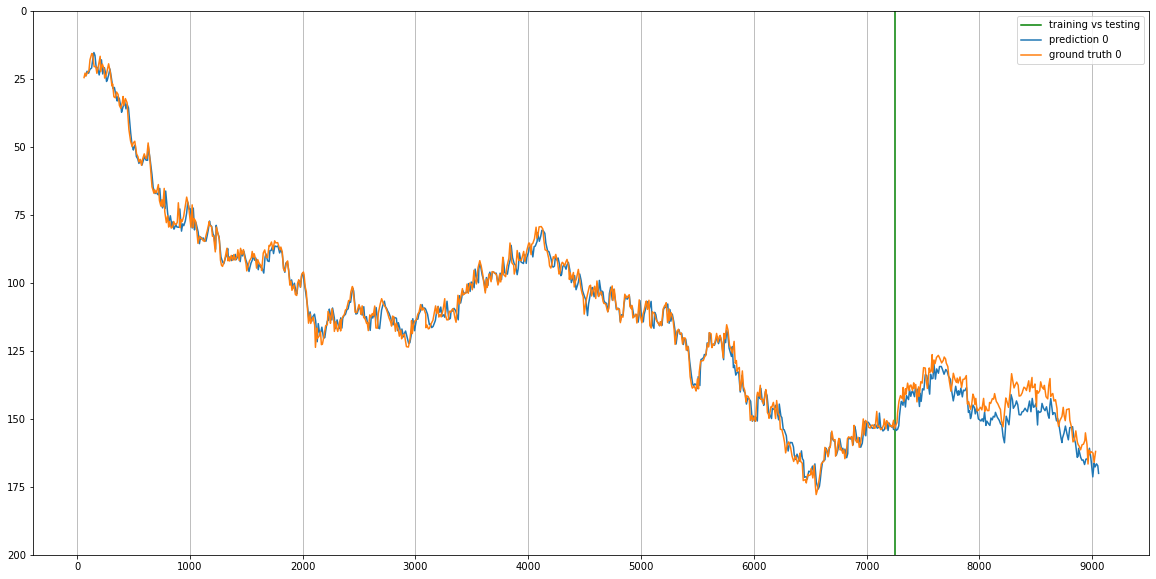

In [20]:
# plot prediction vs truth
plot_prediction(data, test_predict_df, train_predict_df, ids=[0])

**Observations**

This experiment gives us some insight into the relationship of one frame with the next one. In particular, we can see that there is a close-to-linear relationship. This can be further confirmed by the fact that a polynomial regression does not improve on the training set and actually performes much worse on the test set (even after regularisation).

## Experiment 2: how many frames in the future can I predict given one frame?

In this experiment we will change the shape of our data. Here we have one input frame and we want to predict n frames in the future.

The data will be in the form (frame, next_n_frames).

**Try to predict n frames in the future**

In [14]:
n = 100

# data in format (frame, next n frames)
df2 = pd.DataFrame(columns=['X', 'y'])

for i in range(n, len(frames)):
    target = []
    for j in range(n-1, -1, -1):
        target = target + frames[i-j]
    df2 = df2.append({'X': frames[i-n], 'y': target}, ignore_index=True)

In [15]:
split_pct = 0.2
split_idx = df2.index.values[-int(split_pct*max(df2.index.values))]

X_train, y_train, X_test, y_test = split(df2, 0.2)

**Linear Regression**

In [16]:
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

print('The model performance for X_train')
y_predict_train = evaluate(X_train, y_train, lin_model)

print('The model performance for X_test')
y_predict_test = evaluate(X_test, y_test, lin_model)

The model performance for X_train
--------------------------------------
RMSE is 5.529781124426898
R2 score is 0.9486594364111124


The model performance for X_test
--------------------------------------
RMSE is 29.495751142994234
R2 score is -2.964524146643485




In [17]:
pred_train = y_predict_train.reshape((y_predict_train.shape[0], n, -1))
pred_test = y_predict_test.reshape((y_predict_test.shape[0], n, -1))

In [18]:
i = 10

pred_train_df = pd.DataFrame(columns=['x', 'y', 'particle', 'frame'])
pred_test_df = pd.DataFrame(columns=['x', 'y', 'particle', 'frame'])

# for every frame from the ith
for f in range(n):
    # for every particle in each frame
    for p in range(0, len(pred_train[i, f]), 2):
        pred_train_df = pred_train_df.append({'x': pred_train[i, f, p], 'y': pred_train[i, f, p+1], 'particle': p/2, 'frame': f}, ignore_index=True)
        
# for every frame from the ith
for f in range(n):
    # for every particle in each frame
    for p in range(0, len(pred_test[i, f]), 2):
        pred_test_df = pred_test_df.append({'x': pred_test[i, f, p], 'y': pred_test[i, f, p+1], 'particle': p/2, 'frame': f}, ignore_index=True)

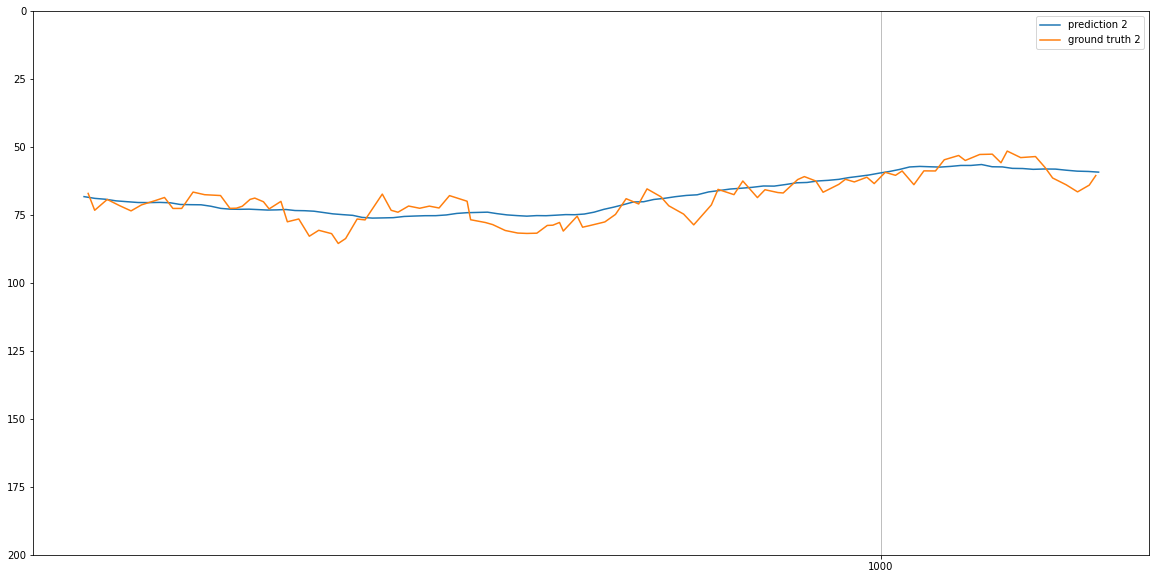

In [19]:
truth_df = data.loc[(data['frame'] > i) & (data['frame'] <= i+n)]
plot_prediction(truth_df, pred_train_df, ids=[2])

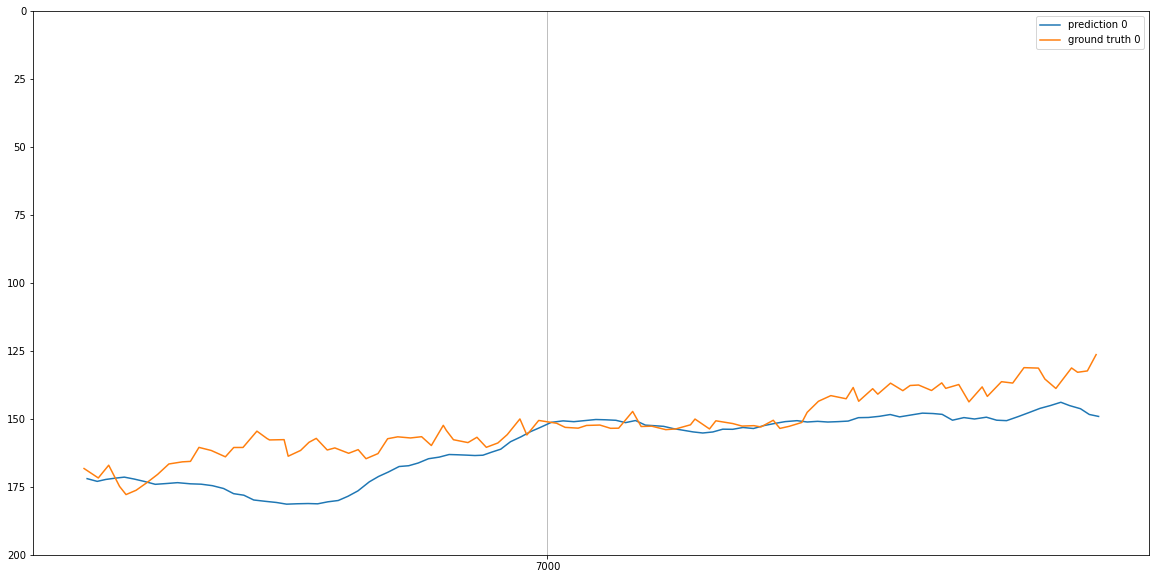

In [20]:
truth_df = data.loc[(data['frame'] > i+split_idx) & (data['frame'] <= i+n+split_idx)]
plot_prediction(truth_df, pred_test_df, ids=[0])

**Poly regression**

In [112]:
steps = [
    ('scalar', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('model', Ridge(alpha=0.5, fit_intercept=True))
]

pipeline = Pipeline(steps)

pipeline.fit(X_train, y_train)

# model avaluation
print('The model performance for X_train')
y_predict_train = evaluate(X_train, y_train, pipeline)

print('The model performance for X_test')
y_predict_test = evaluate(X_test, y_test, pipeline)

The model performance for X_train
--------------------------------------
RMSE is 3.5520968734795164
R2 score is 0.9817812048047015


The model performance for X_test
--------------------------------------
RMSE is 66.96272158645594
R2 score is -14.778353932780503




In [113]:
pred_train = y_predict_train.reshape((y_predict_train.shape[0], n, -1))
pred_test = y_predict_test.reshape((y_predict_test.shape[0], n, -1))

In [114]:
i = 10

pred_train_df = pd.DataFrame(columns=['x', 'y', 'particle', 'frame'])
pred_test_df = pd.DataFrame(columns=['x', 'y', 'particle', 'frame'])

# for every frame from the ith
for f in range(n):
    # for every particle in each frame
    for p in range(0, len(pred_train[i, f]), 2):
        pred_train_df = pred_train_df.append({'x': pred_train[i, f, p], 'y': pred_train[i, f, p+1], 'particle': p/2, 'frame': f}, ignore_index=True)
        
# for every frame from the ith
for f in range(n):
    # for every particle in each frame
    for p in range(0, len(pred_test[i, f]), 2):
        pred_test_df = pred_test_df.append({'x': pred_test[i, f, p], 'y': pred_test[i, f, p+1], 'particle': p/2, 'frame': f}, ignore_index=True)

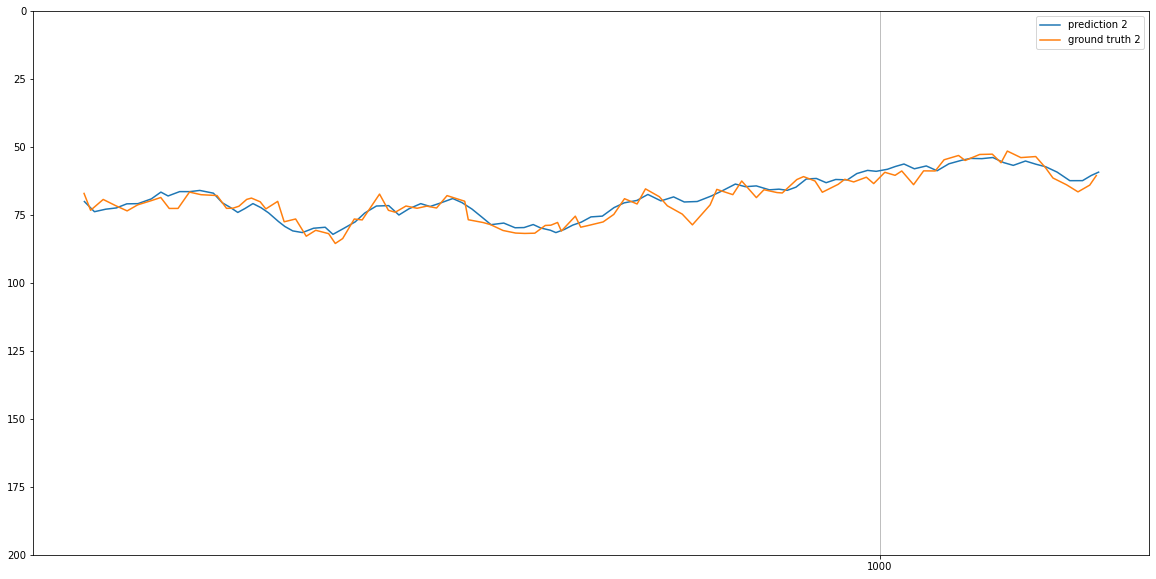

In [115]:
truth_df = data.loc[(data['frame'] > i) & (data['frame'] <= i+n)]
plot_prediction(truth_df, pred_train_df, ids=[2])

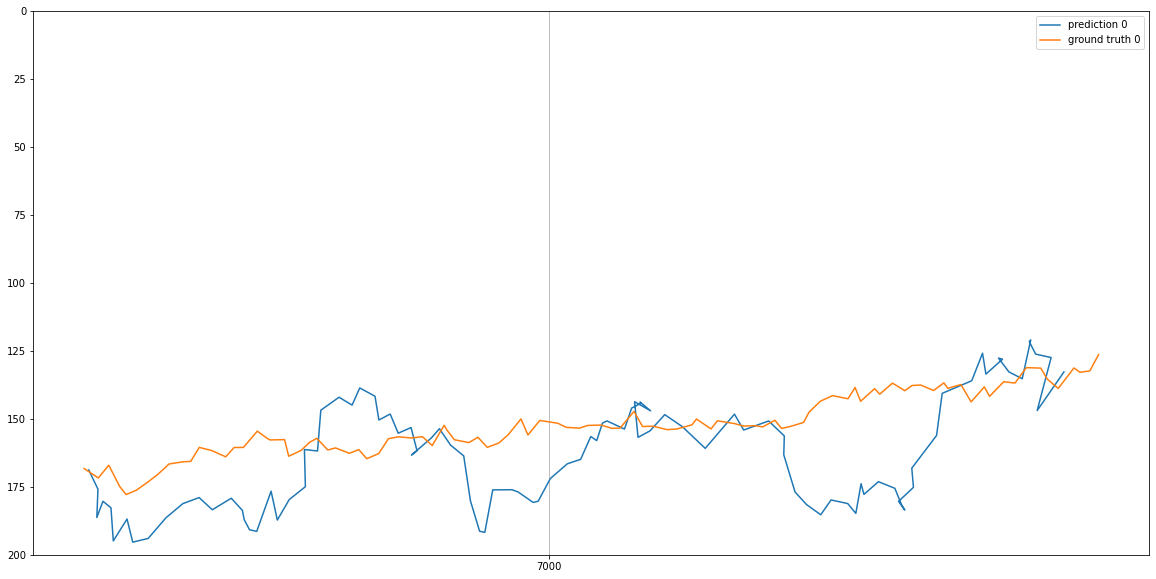

In [116]:
truth_df = data.loc[(data['frame'] > i+split_idx) & (data['frame'] <= i+n+split_idx)]
plot_prediction(truth_df, pred_test_df, ids=[0])

**Observations**

At first (i = 0, i = 1), this seemes to work quite well for both training and test set on poly linear and polynomial regression,. But we can clearly see that with higher values of i, both models start performing very poorly on the test set. This means that neither model manages to geenralise the behaviour of the ensamble.

**For which vaue of n does the model start performing poorly on the test set?**

In this part of the experiment we will consider a different n's and see when the model start performing poorly. We will consider a poor perormance if the RMSE > 10.0 and R2 < 0.6

In [49]:
for n in range(1, 10):
    # data in format (frame, next n frames)
    df2 = pd.DataFrame(columns=['X', 'y'])

    for i in range(n, len(frames)):
        target = []
        for j in range(n-1, -1, -1):
            target = target + frames[i-j]
        df2 = df2.append({'X': frames[i-n], 'y': target}, ignore_index=True)
        
    split_pct = 0.2
    split_idx = df2.index.values[-int(split_pct*max(df2.index.values))]

    X_train, y_train, X_test, y_test = split(df2, 0.2)
    
    lin_model = LinearRegression()
    lin_model.fit(X_train, y_train)
    
    print('***** n = ' + str(n) + ' *****')
    print('The model performance for X_train')
    y_predict_train = evaluate(X_train, y_train, lin_model)

    print('The model performance for X_test')
    y_predict_test = evaluate(X_test, y_test, lin_model)

***** n = 1 *****
The model performance for X_train
--------------------------------------
RMSE is 3.416191282758604
R2 score is 0.9854093671582872


The model performance for X_test
--------------------------------------
RMSE is 5.964209454235747
R2 score is 0.8295229850253383


***** n = 2 *****
The model performance for X_train
--------------------------------------
RMSE is 3.6999887316266276
R2 score is 0.9825840373111144


The model performance for X_test
--------------------------------------
RMSE is 7.170931264634444
R2 score is 0.7539869314756348


***** n = 3 *****
The model performance for X_train
--------------------------------------
RMSE is 3.945566660026862
R2 score is 0.979935899871649


The model performance for X_test
--------------------------------------
RMSE is 8.508833669270901
R2 score is 0.6540627982483557


***** n = 4 *****
The model performance for X_train
--------------------------------------
RMSE is 4.153520287300575
R2 score is 0.9775818005329567


The mod

In [50]:
pred_train = y_predict_train.reshape((y_predict_train.shape[0], n, -1))
pred_test = y_predict_test.reshape((y_predict_test.shape[0], n, -1))

In [51]:
i = 10

pred_train_df = pd.DataFrame(columns=['x', 'y', 'particle', 'frame'])
pred_test_df = pd.DataFrame(columns=['x', 'y', 'particle', 'frame'])

# for every frame from the ith
for f in range(n):
    # for every particle in each frame
    for p in range(0, len(pred_train[i, f]), 2):
        pred_train_df = pred_train_df.append({'x': pred_train[i, f, p], 'y': pred_train[i, f, p+1], 'particle': p/2, 'frame': f}, ignore_index=True)
        
# for every frame from the ith
for f in range(n):
    # for every particle in each frame
    for p in range(0, len(pred_test[i, f]), 2):
        pred_test_df = pred_test_df.append({'x': pred_test[i, f, p], 'y': pred_test[i, f, p+1], 'particle': p/2, 'frame': f}, ignore_index=True)

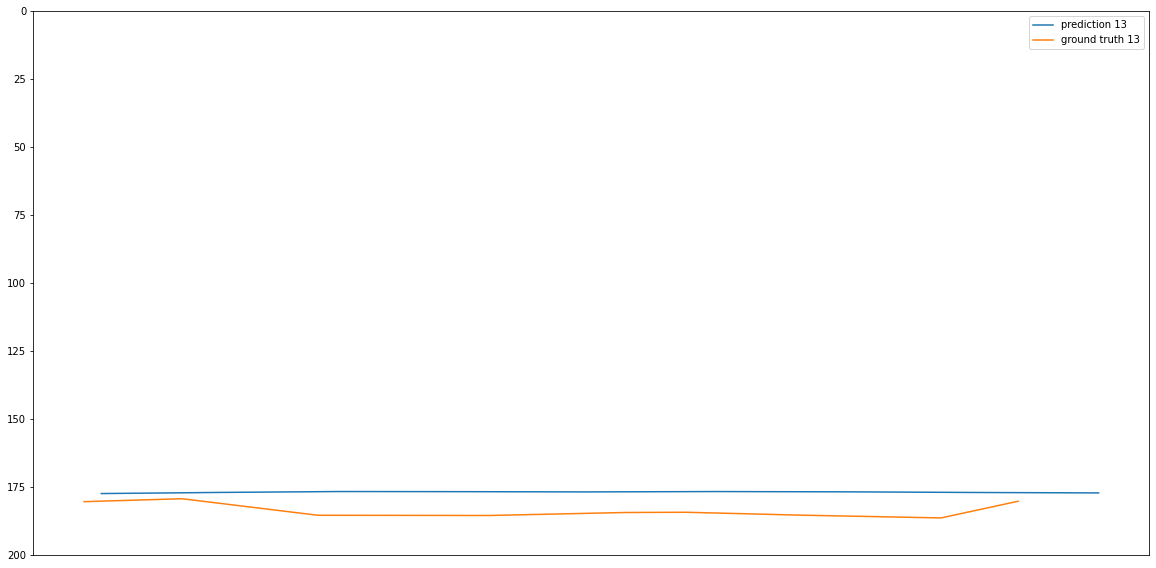

In [65]:
truth_df = data.loc[(data['frame'] > i) & (data['frame'] <= i+n)]
plot_prediction(truth_df, pred_train_df, ids=[13])

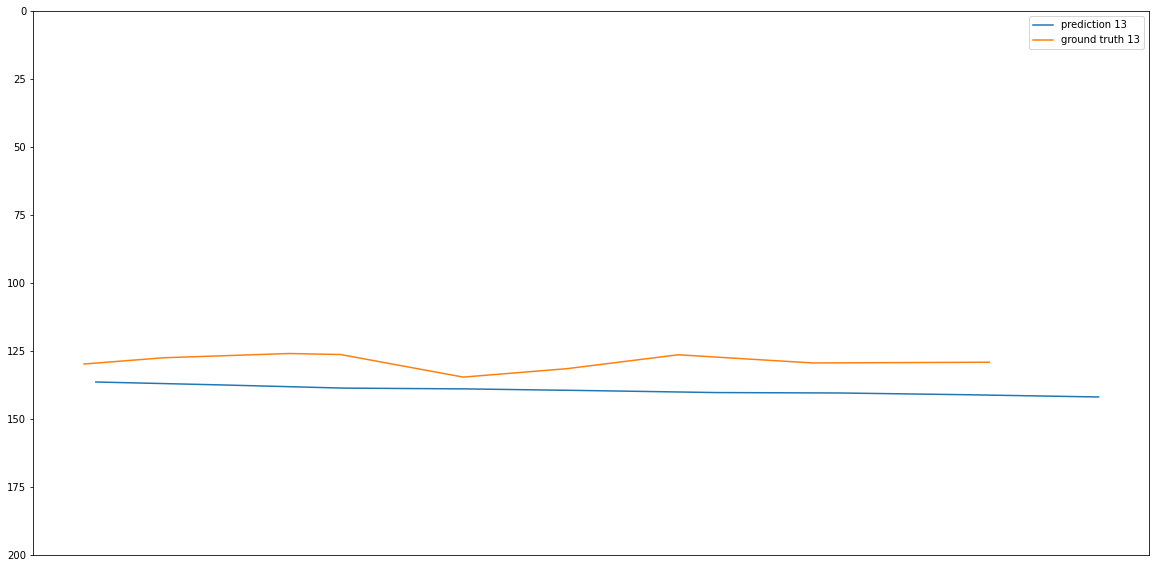

In [64]:
truth_df = data.loc[(data['frame'] > i+split_idx) & (data['frame'] <= i+n+split_idx)]
plot_prediction(truth_df, pred_test_df, ids=[13])

**Observations**

We can see that for n > 3, the RMSE is close to 10.0 and the R2 score < 0.6, which means that the model does not capture the variance of the data well enough.

## Experiment 3: how are the results affected if I try to predict on using my prediction as input data? For how many rounds can this be accurate enough?

In this experiment the data for the model is in the same format as in experiment 1, but now we will try to keep predicting frames in the future and see how far this can go.

**Try to predict n times**

In [39]:
n = 500

# data in columns format (frame, next frame, next next frame, ...)
df3 = pd.DataFrame(columns=['X', 'y_1'])

for i in range(1, n):
    df3['y_' + str(i+1)] = ''

for i in range(n+1):
    col = []
    for j in range(i, len(frames)-n+i):
        col.append(frames[j])
    if i == 0:
        df3['X'] = col
    else:
        df3['y_' + str(i)] = col

In [40]:
X_train, y_train, X_test, y_test = split(df3, 0.2)

We train the model on the first two columns.

**Linear Regression**

In [41]:
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

print('The model performance for X_train')
y_predict_train = evaluate(X_train, y_train, lin_model)

print('The model performance for X_test')
y_predict_test = evaluate(X_test, y_test, lin_model)

The model performance for X_train
--------------------------------------
RMSE is 3.073839587695034
R2 score is 0.9748419040974174


The model performance for X_test
--------------------------------------
RMSE is 6.45747410607881
R2 score is 0.5654079937350226




In [42]:
# prediction to dataframe
train_predict_df = get_predictions_df(y_predict_train)
test_predict_df = get_predictions_df(y_predict_test)

Prediction to dataframe: 100%|███████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 54.27it/s]


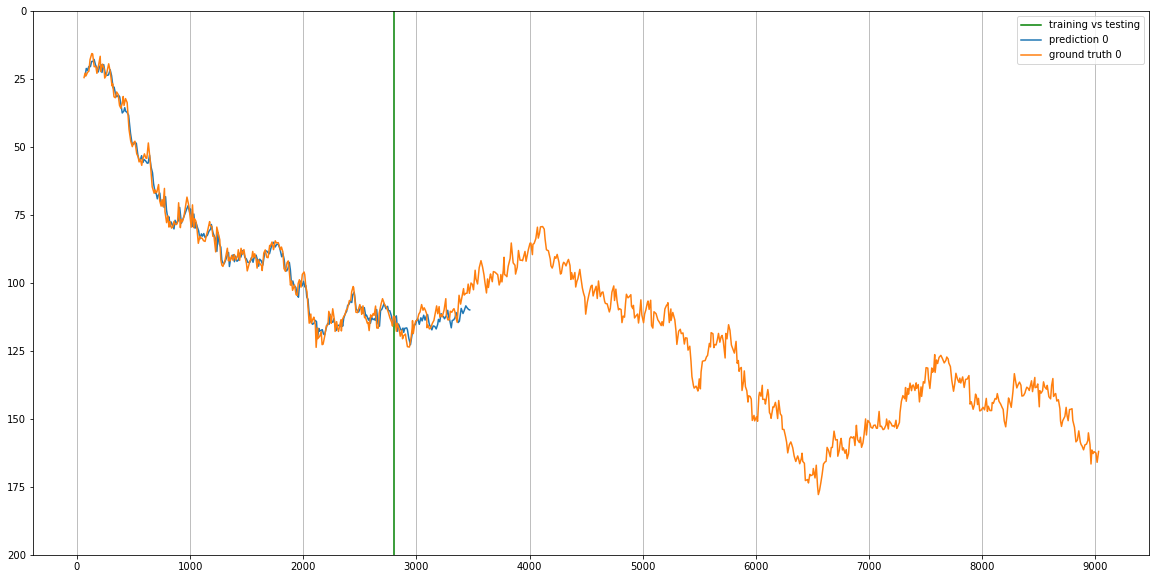

In [43]:
# plot prediction vs truth
plot_prediction(data, test_predict_df, train_predict_df, ids=[0])

In [44]:
y_i_predict =  lin_model.predict(X_train+X_test)

for i in range(1, n):
    print("The model performance for y_{} -> y_{}".format(i, i+1))
    y_i_predict = evaluate(y_i_predict, df3['y_' + str(i+1)].tolist(), lin_model)

The model performance for y_1 -> y_2
--------------------------------------
RMSE is 5.122226683295398
R2 score is 0.941137921146996


The model performance for y_2 -> y_3
--------------------------------------
RMSE is 5.927331422444227
R2 score is 0.9231679304139333


The model performance for y_3 -> y_4
--------------------------------------
RMSE is 6.531789904344518
R2 score is 0.9113912742085483


The model performance for y_4 -> y_5
--------------------------------------
RMSE is 7.009057131072795
R2 score is 0.9036294932595929


The model performance for y_5 -> y_6
--------------------------------------
RMSE is 7.420499875518808
R2 score is 0.8964400601241017


The model performance for y_6 -> y_7
--------------------------------------
RMSE is 7.761973285336042
R2 score is 0.8905645809881638


The model performance for y_7 -> y_8
--------------------------------------
RMSE is 8.071905530007715
R2 score is 0.8843741777655303


The model performance for y_8 -> y_9
-------------------

In [45]:
# get predictions from j to j+n

# this needs to be such that j+n < total number of frames
j = 0

# these are the n frames starting from frame j to j+n (ground truth)
truth = df3.iloc[j].values.tolist()

predictions = []
predictions.append((X_train+X_test)[j])

y_i_predict = lin_model.predict(X_train+X_test)
predictions.append(y_i_predict[j].tolist())

for i in range(1, n):
    y_i_predict = lin_model.predict(y_i_predict)
    predictions.append(y_i_predict[j].tolist())

In [46]:
# place data in df

# truth_df = get_predictions_df(truth)
pred_df = get_predictions_df(predictions)

Prediction to dataframe: 100%|█████████████████████████████████████████████████████████████████████████████████████| 501/501 [00:08<00:00, 56.90it/s]


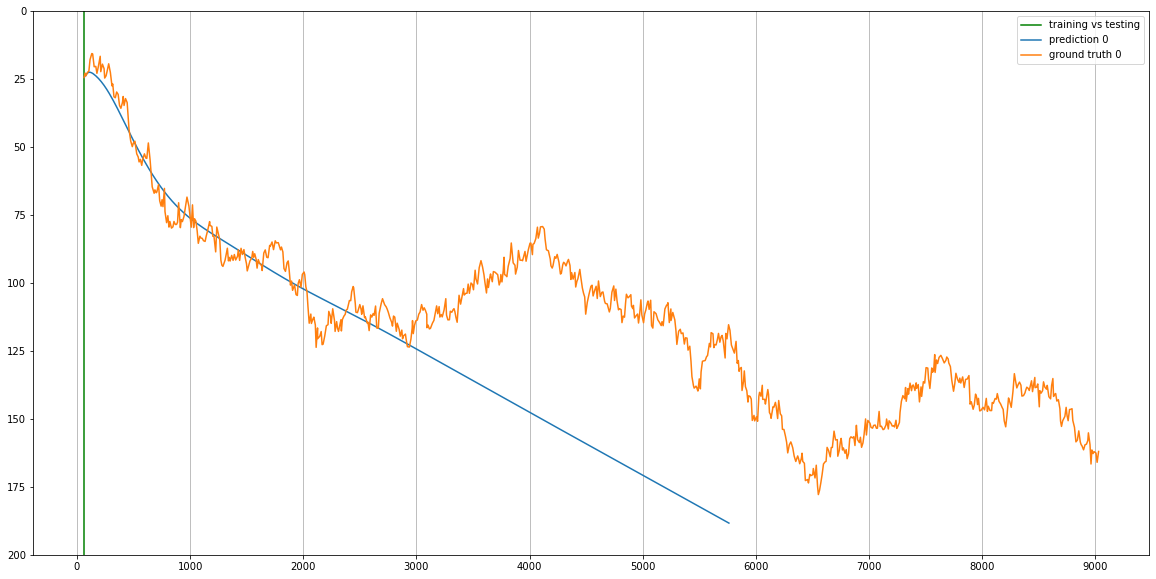

In [47]:
plot_prediction(data, pred_df[pred_df['frame'] > 0], pred_df[pred_df['frame'] == 0], ids=[0])

The following plot is just to see how the prediction frames -> next_frame is on the entire dataset (this time tha training is on a much smaller set compared to experiment 1)

Prediction to dataframe: 100%|█████████████████████████████████████████████████████████████████████████████████████| 559/559 [00:09<00:00, 57.72it/s]


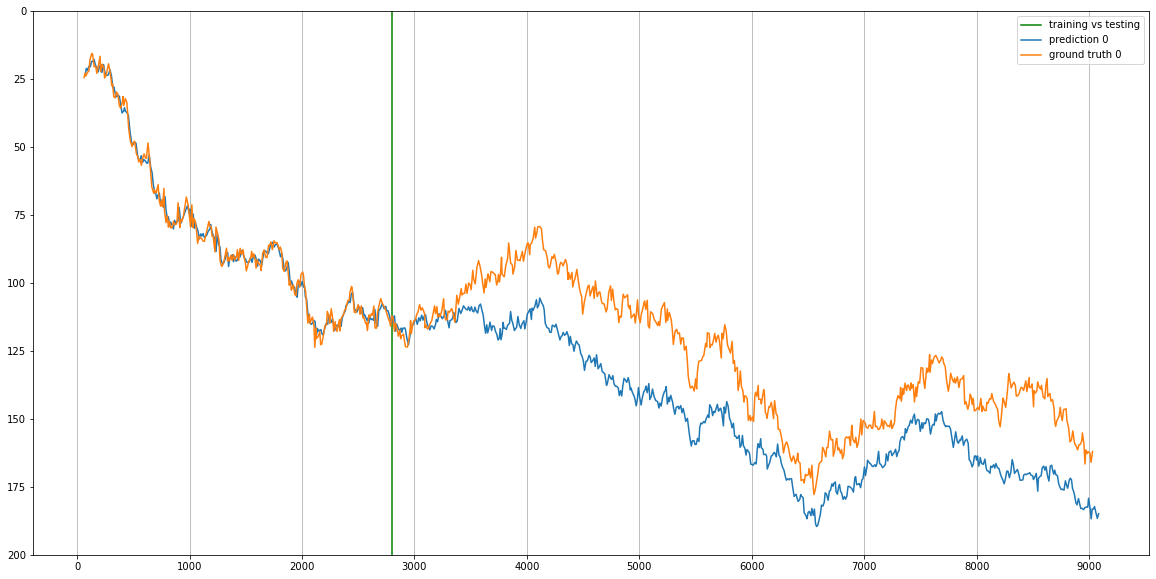

In [48]:
pred = lin_model.predict(frames)
pred = pred[len(y_predict_train):, :]

pred_df = get_predictions_df(pred)
plot_prediction(data, pred_df, train_predict_df, ids=[0])

## Analyse behaviour of subsets of skyrmions (only cosider the ones in the top half, bottom half, centre)

In [49]:
# top qurter
top = data.copy()
# bottom qurter
bottom = data.copy()
# middle quarter
centre = data.copy()

# drop particles that do not start in the top/bottom/centre of the 
# construct top
particles_to_keep = []
for index, row in data[data['frame'] == 0].iterrows():
    if row['y'] < max(data['y']) / 4:
        particles_to_keep.append(row['particle'])
        
for index, row in tqdm(top.iterrows()):
    if row['particle'] not in particles_to_keep:
        top = top.drop(index)

# construct bottom
particles_to_keep = []
for index, row in data[data['frame'] == 0].iterrows():
    if row['y'] > 3 * (max(data['y']) / 4):
        particles_to_keep.append(row['particle'])
        
for index, row in tqdm(bottom.iterrows()):
    if row['particle'] not in particles_to_keep:
        bottom = bottom.drop(index)

# construct centre
particles_to_keep = []
for index, row in data[data['frame'] == 0].iterrows():
    if row['y'] > 3 * (max(data['y']) / 8) and row['y'] < 5 * (max(data['y']) / 8):
        particles_to_keep.append(row['particle'])
        
for index, row in tqdm(centre.iterrows()):
    if row['particle'] not in particles_to_keep:
        centre = centre.drop(index)

12000it [00:05, 2187.25it/s]
12000it [00:04, 2419.47it/s]
12000it [00:05, 2268.50it/s]


**Analyse Top**

In [50]:
top.describe()

,y,x,frame,particle
count,1600.000000,1600.000000,1600.00000,1600.000000
mean,91.646874,4534.113318,399.50000,0.500000
std,35.653440,2577.574292,231.01213,0.500156
min,15.109391,61.809992,0.00000,0.000000
25%,69.341467,2294.652841,199.75000,0.000000
50%,87.821167,4522.438422,399.50000,0.500000
75%,113.762225,6771.479529,599.25000,1.000000
max,177.842924,9030.630412,799.00000,1.000000


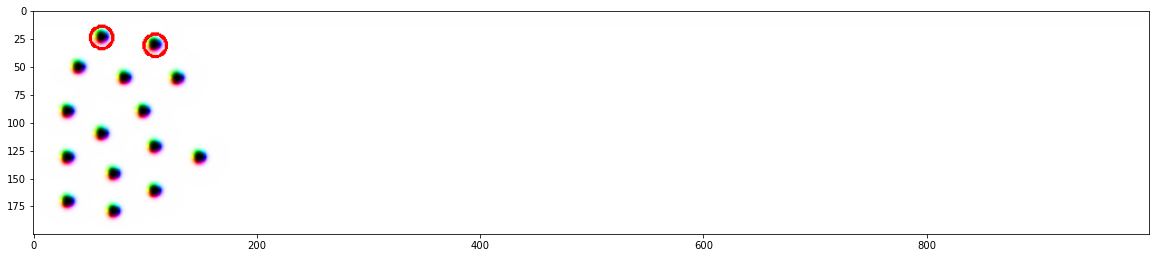

In [51]:
show_tracked(top, directory)

The skyrmions move throughout the entire y-axis. Of course their behaviour is influenced by other skyrmions in the ensamble as well. But it seems like there is no tendency of skyrmoins remaining at the top when startin there. This can be observed in both the plot and the tbale above (mean is close to 100).

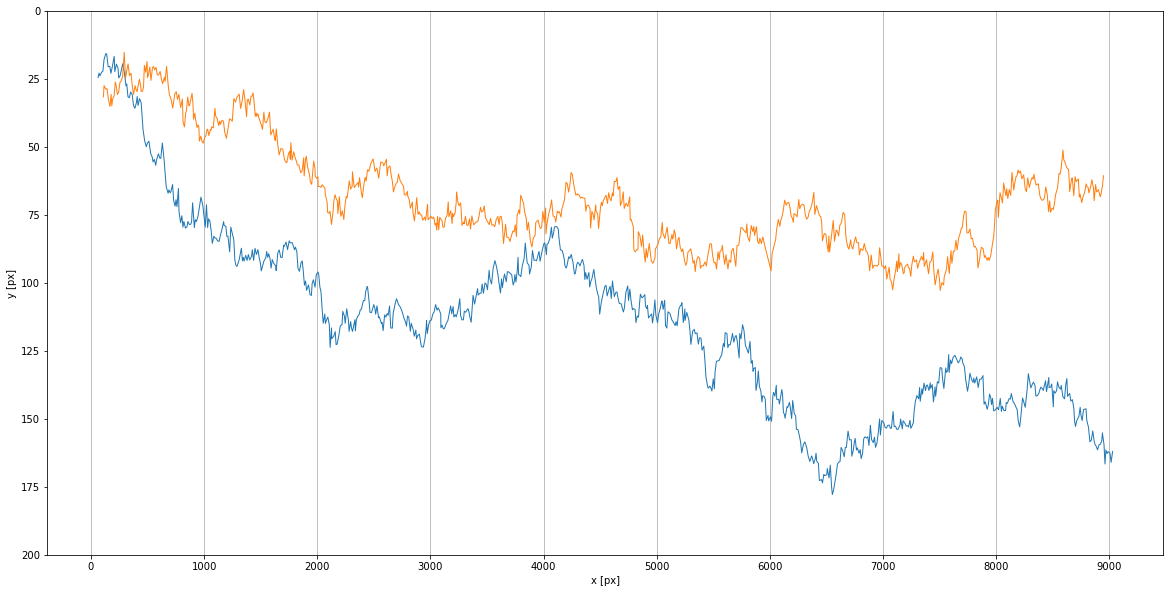

In [52]:
plt.figure(figsize=(20, 10))
plt.grid(True, axis='x')
plt.xticks(np.arange(0, max(top['x'])+1, 1000.0))
plt.ylim(0, 200)
tp.plot_traj(top)

**Analyse Bottom**

In [53]:
bottom.describe()

,y,x,frame,particle
count,3200.000000,3200.000000,3200.00000,3200.000000
mean,137.680046,4392.376980,399.50000,12.500000
std,41.892480,2512.624307,230.97602,1.118209
min,15.437867,31.206029,0.00000,11.000000
25%,111.917488,2215.992326,199.75000,11.750000
50%,155.502694,4384.494667,399.50000,12.500000
75%,167.014834,6556.735970,599.25000,13.250000
max,188.012413,8909.539660,799.00000,14.000000


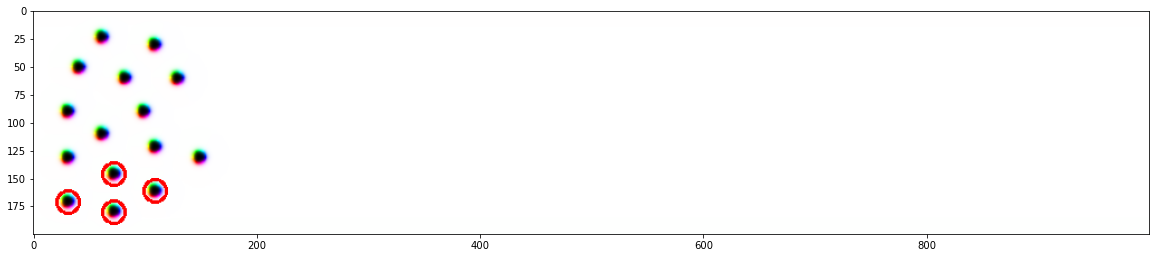

In [54]:
show_tracked(bottom, directory)

Here skyrmions seem to behave a bit differently from the ones in the top quarter as 3 of the 4 skyrmions mostly stay in the bottom half, hence it seems like the strongest interactions are among the skyrmoins in the sub-ensable rather than with all the further ones as well.

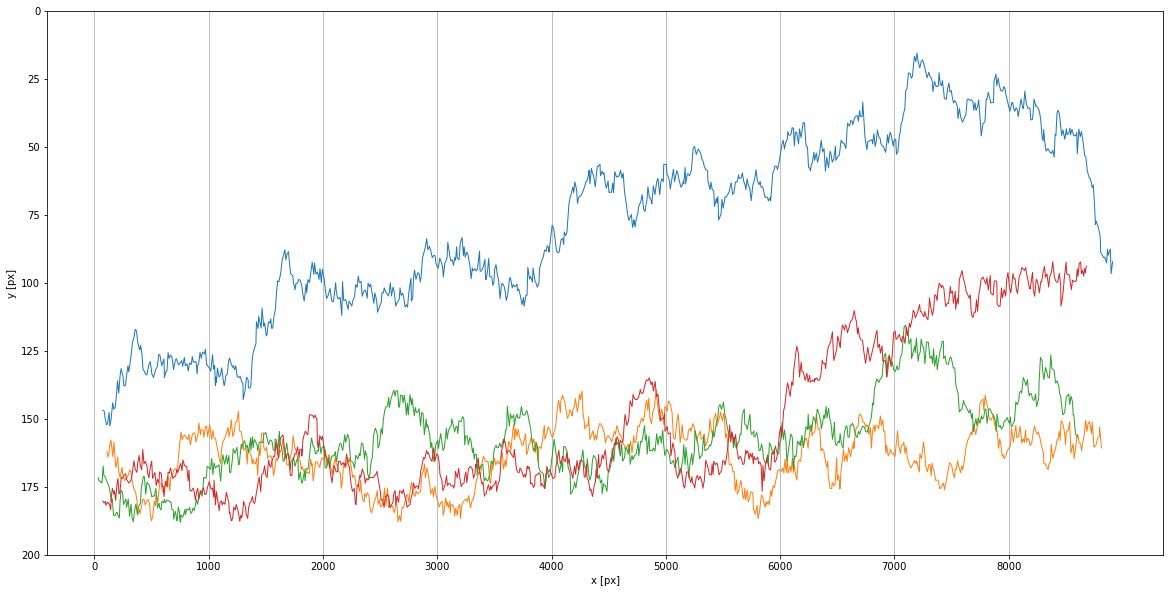

In [55]:
plt.figure(figsize=(20, 10))
plt.grid(True, axis='x')
plt.xticks(np.arange(0, max(bottom['x'])+1, 1000.0))
plt.ylim(0, 200)
tp.plot_traj(bottom)

**Analyse Centre**

In [56]:
centre.describe()

,y,x,frame,particle
count,2400.000000,2400.000000,2400.000000,2400.000000
mean,124.494654,4384.496409,399.500000,6.000000
std,38.239116,2514.763499,230.988055,0.816667
min,20.971020,31.088248,0.000000,5.000000
25%,96.921945,2203.571816,199.750000,5.000000
50%,126.848526,4355.232439,399.500000,6.000000
75%,156.733882,6549.055436,599.250000,7.000000
max,186.792020,8844.332414,799.000000,7.000000


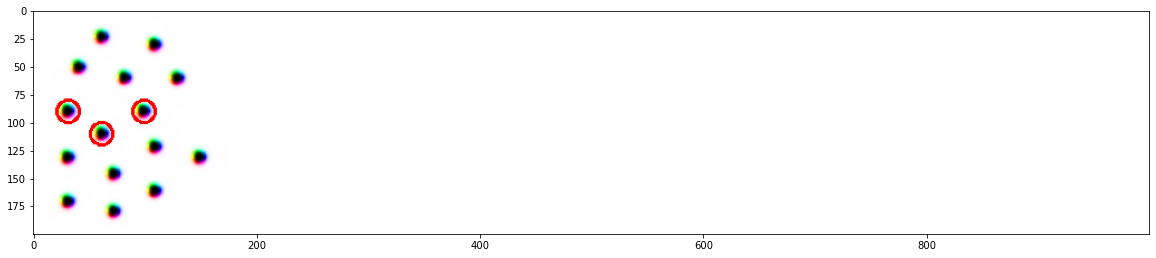

In [57]:
show_tracked(centre, directory)

The middle quarter is quite interesting as one skyrmion seems to almost move independently of the other two, but the lower ones seem to be moving almost together in the second half of the plot.

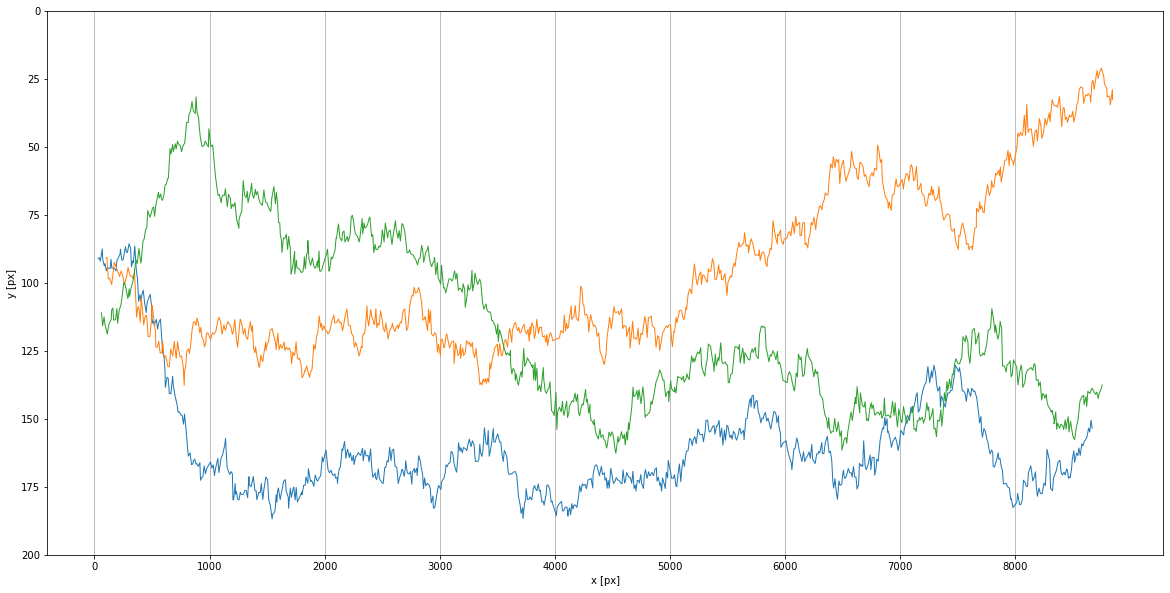

In [58]:
plt.figure(figsize=(20, 10))
plt.grid(True, axis='x')
plt.xticks(np.arange(0, max(centre['x'])+1, 1000.0))
plt.ylim(0, 200)
tp.plot_traj(centre)

## Experiment 4: linear regression with randomly chosen half of the particles and predict others

**Let's use half of the particles to train and the rest to test**

In [59]:
ids = list(range(0, no_skyrmions))

train_ids = random.sample(ids, k=7)
train_ids.sort()
ids = [x for x in ids if x not in train_ids]

test_ids = random.sample(ids, k=7)
test_ids.sort()

train_data = data[data['particle'].isin(train_ids)]
test_data = data[data['particle'].isin(test_ids)]

**Train data**


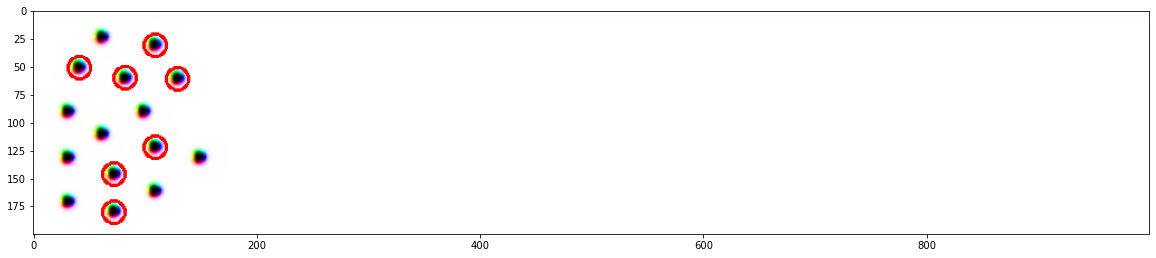

**Test data**


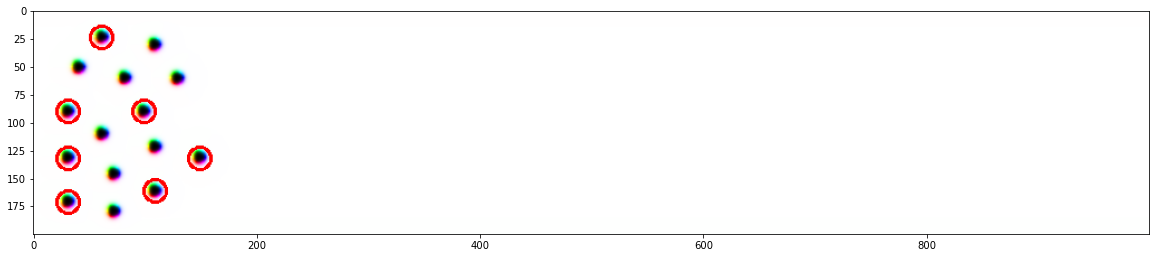

In [60]:
print('**Train data**')
show_tracked(train_data, directory)
print('**Test data**')
show_tracked(test_data, directory)

In [61]:
train_frames = get_frames(train_data)
test_frames = get_frames(test_data)

X_train, y_train = frames_to_xy(train_frames)
X_test, y_test = frames_to_xy(test_frames)

Getting frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:03<00:00, 254.65it/s]


In [62]:
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

print('The model performance for X_train')
y_predict_train = evaluate(X_train, y_train, lin_model)

print('The model performance for X_test')
y_predict_test = evaluate(X_test, y_test, lin_model)

The model performance for X_train
--------------------------------------
RMSE is 3.5230018060663912
R2 score is 0.9891238657188265


The model performance for X_test
--------------------------------------
RMSE is 8.958358352653859
R2 score is 0.8508813456012915




In [63]:
pred_train_df = get_predictions_df(y_predict_train, train_ids)
pred_test_df = get_predictions_df(y_predict_test, test_ids)

Prediction to dataframe: 100%|████████████████████████████████████████████████████████████████████████████████████| 799/799 [00:06<00:00, 126.68it/s]


In [64]:
print(f'Train ids: {train_ids}')

Train ids: [1, 2, 3, 4, 8, 11, 14]


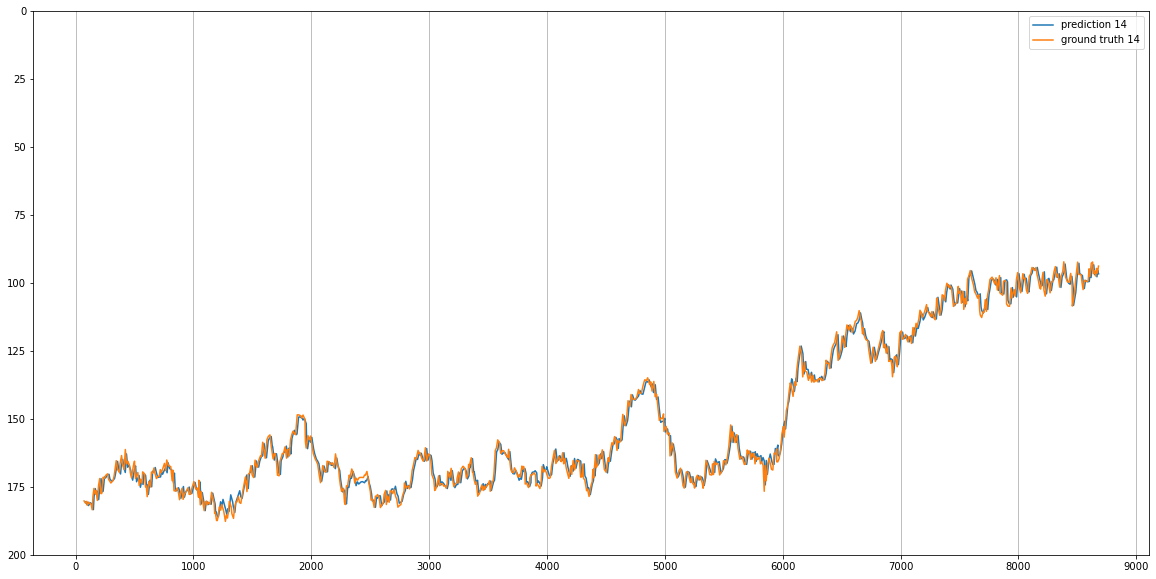

In [65]:
plot_prediction(data, pred_train_df, ids=[train_ids[-1]])

In [66]:
print(f'Test ids: {test_ids}')

Test ids: [0, 5, 6, 9, 10, 12, 13]


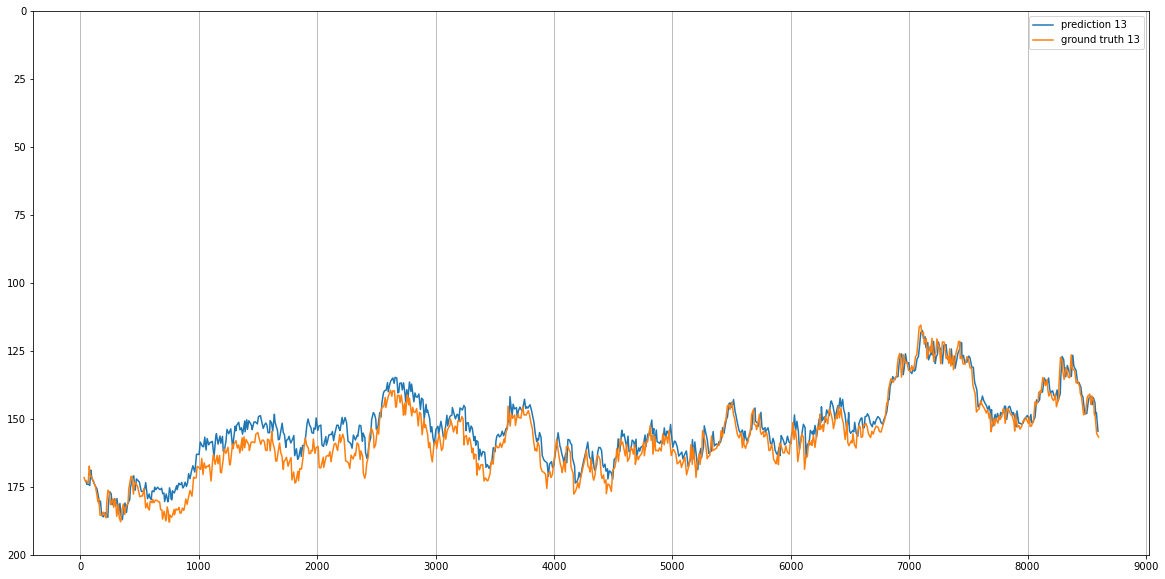

In [67]:
plot_prediction(data, pred_test_df, ids=[test_ids[-1]])

This approach is not good as it requires the training and testing sets to contain the same number of skyrmions, but what if I wanna train with 60% and test with 40%? Also if the number of skyrmions is odd, one skyrmion will be left out.

## Experiment 5: linear regression with top half of the particles and predict others and vice versa

**Select the top half for linear regression and bottom for testing**

In [68]:
train_ids = data[data['frame'] == 0].nsmallest(7, 'y')['particle'].tolist()
test_ids = data[data['frame'] == 0].nlargest(7, 'y')['particle'].tolist()

train_ids.sort()
test_ids.sort()

train_data = data[data['particle'].isin(train_ids)]
test_data = data[data['particle'].isin(test_ids)]

**Train data**


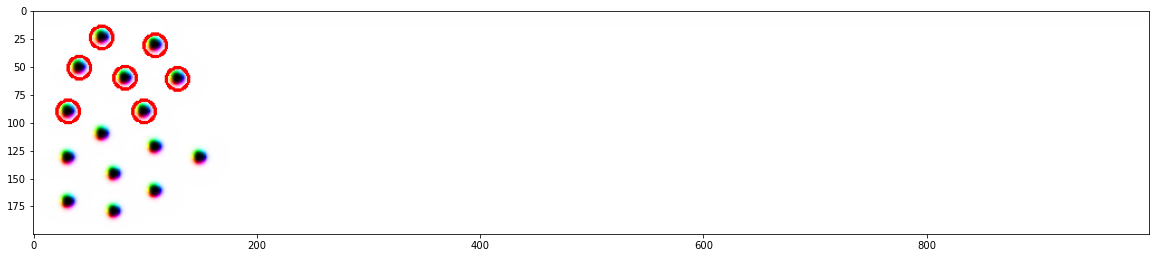

**Test data**


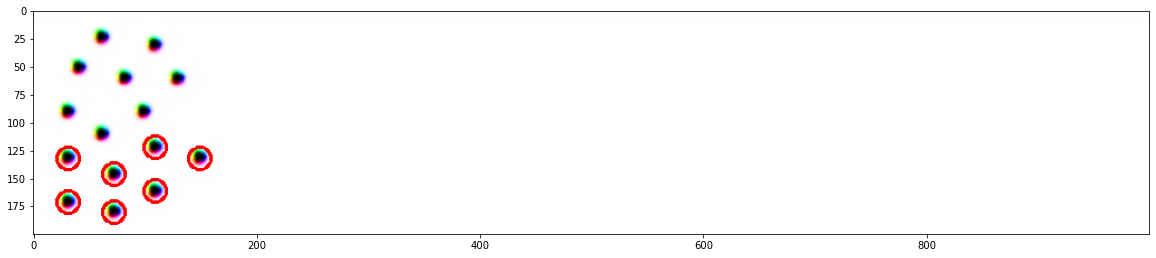

In [69]:
print('**Train data**')
show_tracked(train_data, directory)
print('**Test data**')
show_tracked(test_data, directory)

In [70]:
train_frames = get_frames(train_data)
test_frames = get_frames(test_data)

X_train, y_train = frames_to_xy(train_frames)
X_test, y_test = frames_to_xy(test_frames)

Getting frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:03<00:00, 252.40it/s]


In [71]:
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

print('The model performance for X_train')
y_predict_train = evaluate(X_train, y_train, lin_model)

print('The model performance for X_test')
y_predict_test = evaluate(X_test, y_test, lin_model)

The model performance for X_train
--------------------------------------
RMSE is 3.5175656804392963
R2 score is 0.9889956708566536


The model performance for X_test
--------------------------------------
RMSE is 12.203441595419543
R2 score is 0.8298237501521045




In [72]:
pred_train_df = get_predictions_df(y_predict_train, train_ids)
pred_test_df = get_predictions_df(y_predict_test, test_ids)

Prediction to dataframe: 100%|████████████████████████████████████████████████████████████████████████████████████| 799/799 [00:06<00:00, 124.77it/s]


In [73]:
print(f'Train ids: {train_ids}')

Train ids: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]


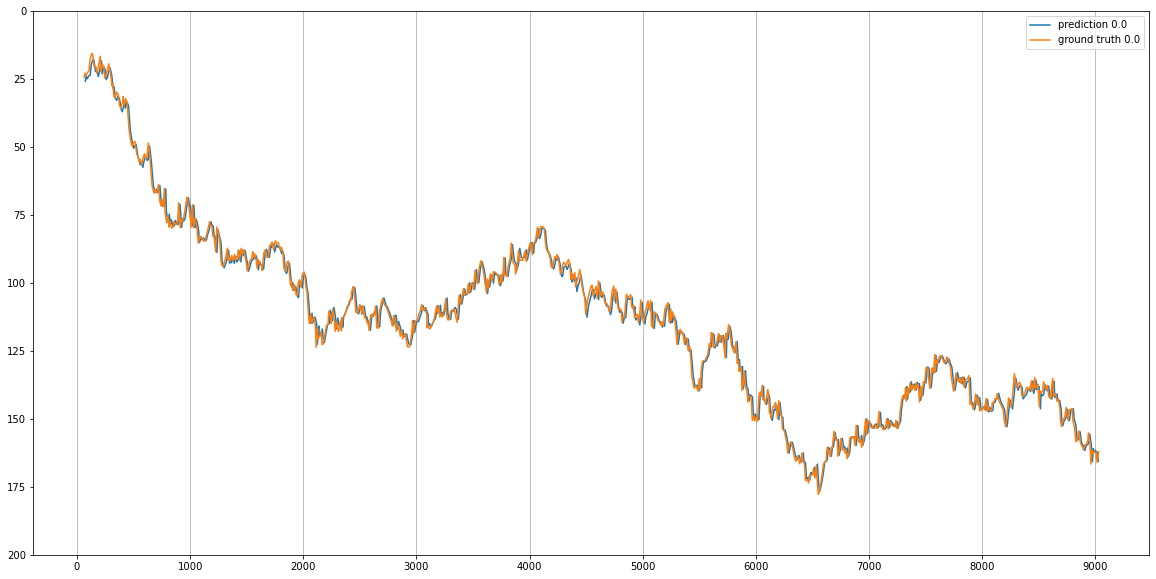

In [77]:
plot_prediction(data, pred_train_df, ids=[train_ids[0]])

In [78]:
print(f'Test ids: {test_ids}')

Test ids: [8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0]


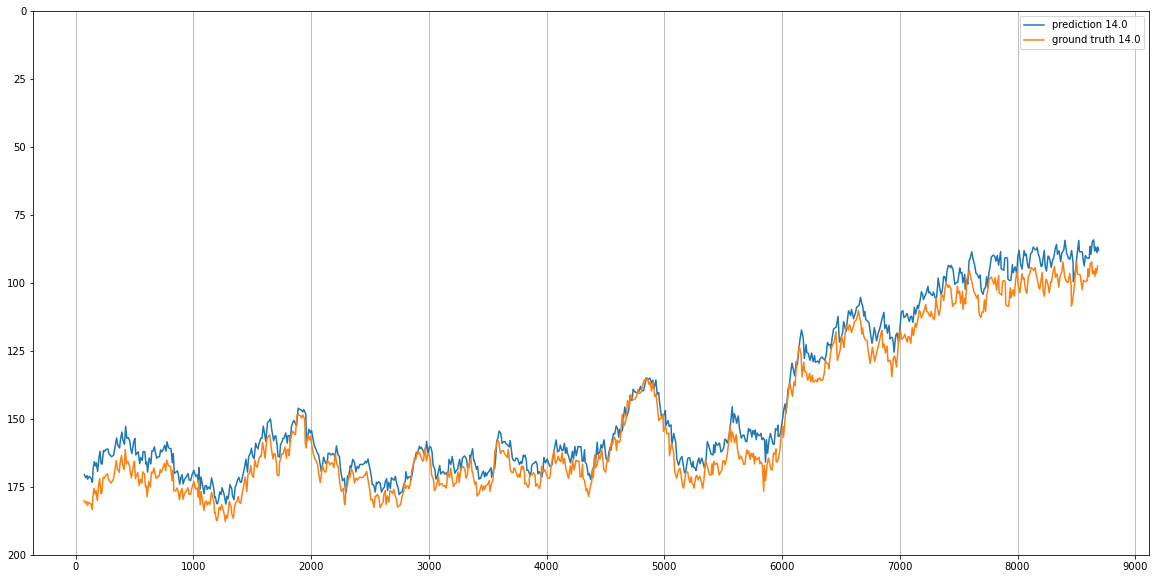

In [80]:
plot_prediction(data, pred_test_df, ids=[test_ids[-1]])

**Select the top half for linear regrassion and bottom for testing**

In [81]:
train_ids = data[data['frame'] == 0].nlargest(7, 'y')['particle'].tolist()
test_ids = data[data['frame'] == 0].nsmallest(7, 'y')['particle'].tolist()

train_ids.sort()
test_ids.sort()

train_data = data[data['particle'].isin(train_ids)]
test_data = data[data['particle'].isin(test_ids)]

**Train data**


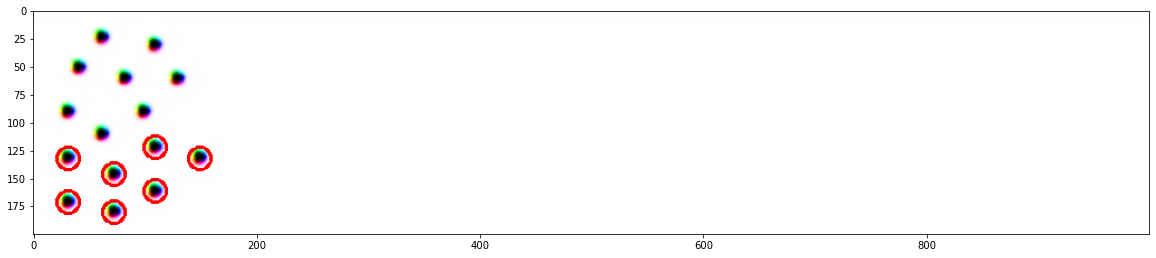

**Test data**


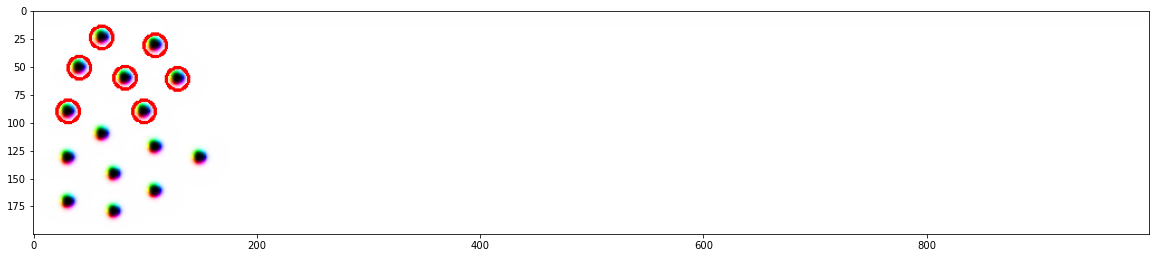

In [82]:
print('**Train data**')
show_tracked(train_data, directory)
print('**Test data**')
show_tracked(test_data, directory)

In [83]:
train_frames = get_frames(train_data)
test_frames = get_frames(test_data)

X_train, y_train = frames_to_xy(train_frames)
X_test, y_test = frames_to_xy(test_frames)

Getting frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:03<00:00, 254.47it/s]


In [84]:
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

print('The model performance for X_train')
y_predict_train = evaluate(X_train, y_train, lin_model)

print('The model performance for X_test')
y_predict_test = evaluate(X_test, y_test, lin_model)

The model performance for X_train
--------------------------------------
RMSE is 3.5031610859735465
R2 score is 0.984826908505804


The model performance for X_test
--------------------------------------
RMSE is 11.126207357629792
R2 score is 0.853651633649081




In [85]:
pred_train_df = get_predictions_df(y_predict_train, train_ids)
pred_test_df = get_predictions_df(y_predict_test, test_ids)

Prediction to dataframe: 100%|████████████████████████████████████████████████████████████████████████████████████| 799/799 [00:06<00:00, 126.58it/s]


In [86]:
print(f'Train ids: {train_ids}')

Train ids: [8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0]


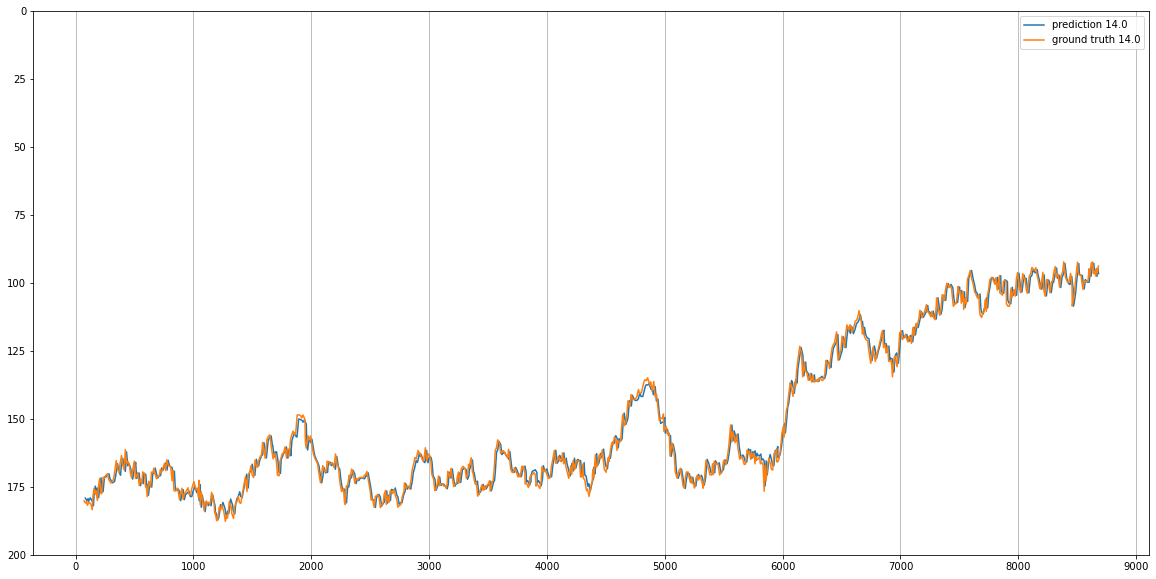

In [87]:
plot_prediction(data, pred_train_df, ids=[train_ids[-1]])

In [88]:
print(f'Test ids: {test_ids}')

Test ids: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]


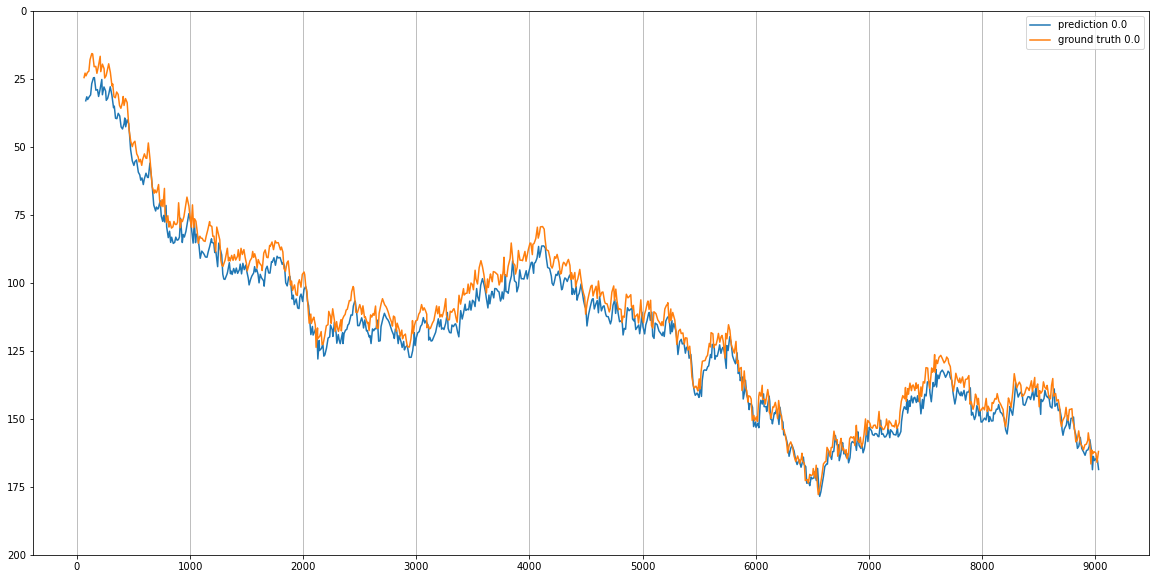

In [90]:
plot_prediction(data, pred_test_df, ids=[test_ids[0]])

## Experiment 6: train on 5 particles chosen at random and predict the other 10 (in two sets of 5)

In [58]:
ids = list(range(0, no_skyrmions))

train_ids = random.sample(ids, k=5)
train_ids.sort()
ids = [x for x in ids if x not in train_ids]

test_1_ids = random.sample(ids, k=5)
test_1_ids.sort()
ids = [x for x in ids if x not in test_1_ids]

test_2_ids = ids
test_2_ids.sort()

**Train data**


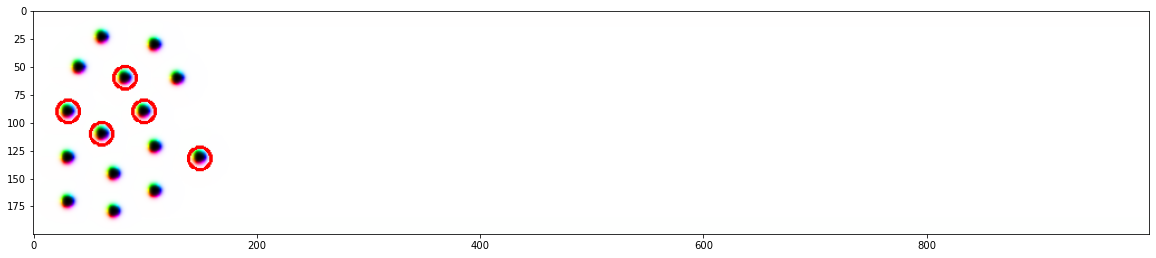

**Test data 1**


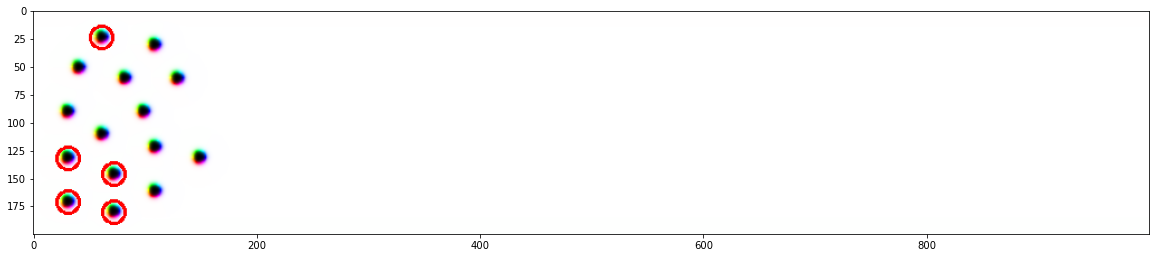

**Test data 2**


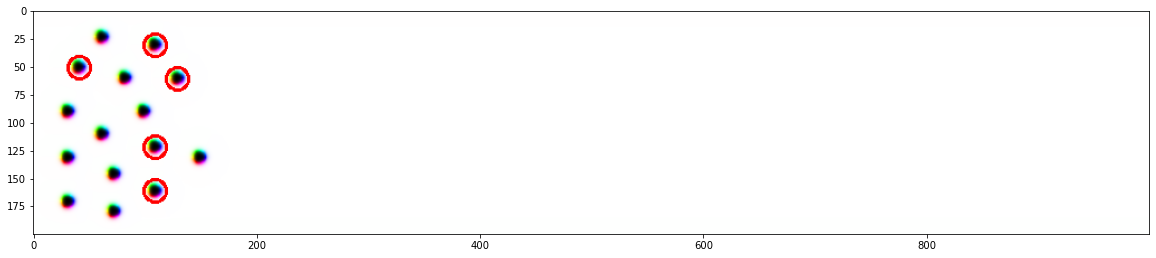

In [59]:
train_data = data[data['particle'].isin(train_ids)]
test_1_data = data[data['particle'].isin(test_1_ids)]
test_2_data = data[data['particle'].isin(test_2_ids)]

print('**Train data**')
show_tracked(train_data, directory)
print('**Test data 1**')
show_tracked(test_1_data, directory)
print('**Test data 2**')
show_tracked(test_2_data, directory)

In [60]:
train_frames = get_frames(train_data)
test_1_frames = get_frames(test_1_data)
test_2_frames = get_frames(test_2_data)

X_train, y_train = frames_to_xy(train_frames)
X_1_test, y_1_test = frames_to_xy(test_1_frames)
X_2_test, y_2_test = frames_to_xy(test_2_frames)

Getting frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 342.50it/s]


In [61]:
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

print("The model performance for training set")
train_pred = evaluate(X_train, y_train, lin_model)

print("The model performance for testing set 1")
test_1_pred = evaluate(X_1_test, y_1_test, lin_model)

print("The model performance for testing set 2")
test_2_pred = evaluate(X_2_test, y_2_test, lin_model)

The model performance for training set
--------------------------------------
RMSE is 3.5895278895959737
R2 score is 0.9922259474029635


The model performance for testing set 1
--------------------------------------
RMSE is 10.860337172349709
R2 score is 0.8989374422303633


The model performance for testing set 2
--------------------------------------
RMSE is 9.133612077021183
R2 score is 0.8572669383167387




In [62]:
pred_train_df = get_predictions_df(train_pred, train_ids)
pred_test_1_df = get_predictions_df(test_1_pred, test_1_ids)
pred_test_2_df = get_predictions_df(test_2_pred, test_2_ids)

Prediction to dataframe: 100%|████████████████████████████████████████████████████████████████████████████████████| 799/799 [00:04<00:00, 174.38it/s]


In [63]:
print(f'Train ids: {train_ids}')

Train ids: [3, 5, 6, 7, 10]


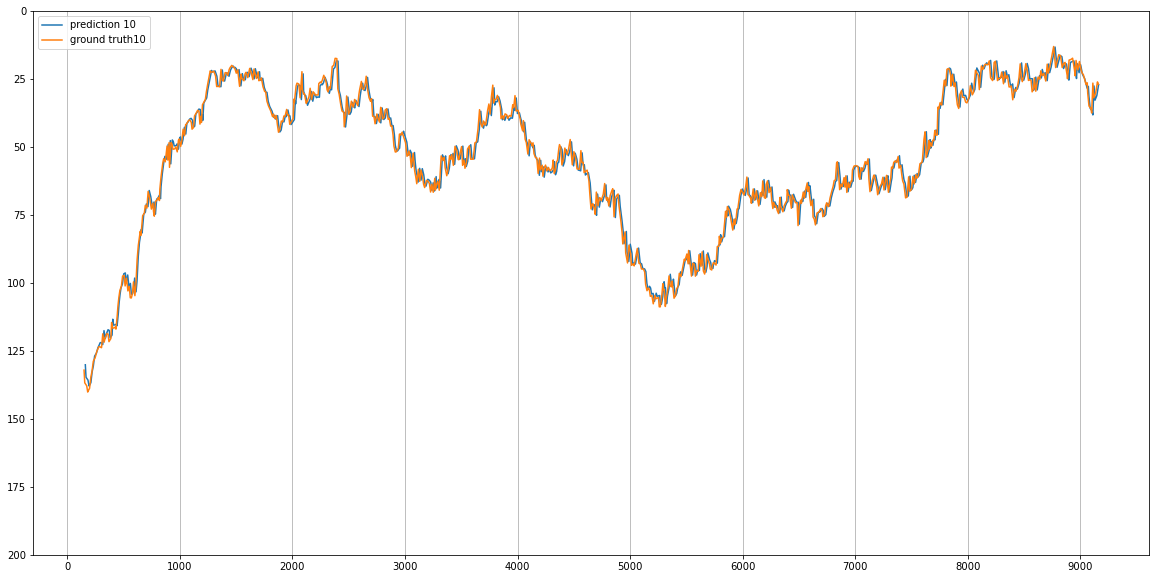

In [64]:
plot_prediction(data, pred_train_df, ids=[train_ids[-1]])

In [65]:
print(f'Test 1 ids: {test_1_ids}')

Test 1 ids: [0, 9, 11, 13, 14]


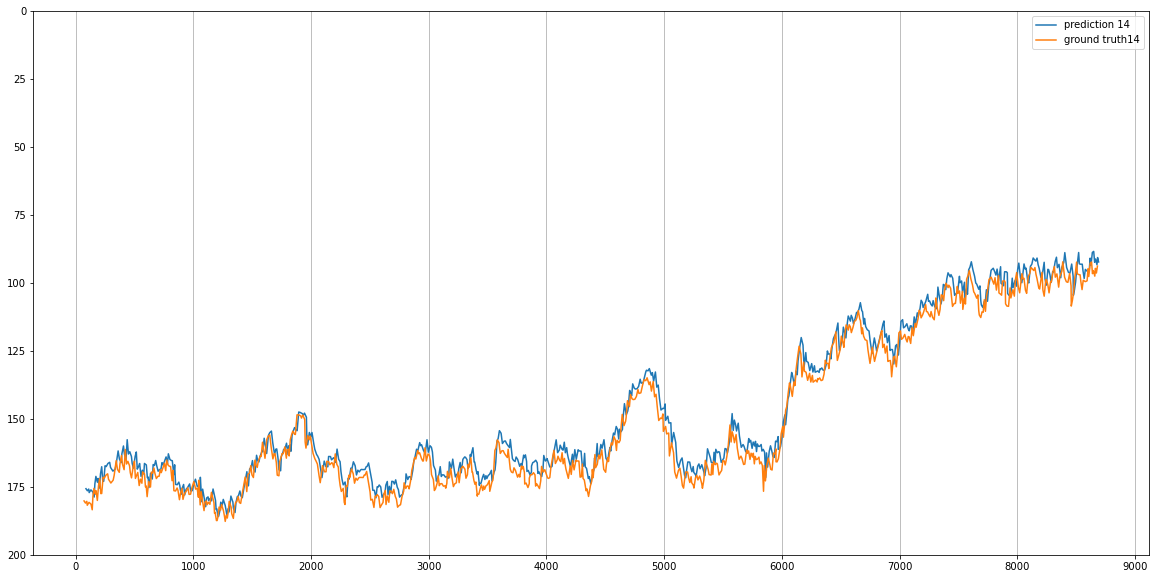

In [66]:
plot_prediction(data, pred_test_1_df, ids=[test_1_ids[-1]])

In [67]:
print(f'Test 2 ids: {test_2_ids}')

Test 2 ids: [1, 2, 4, 8, 12]


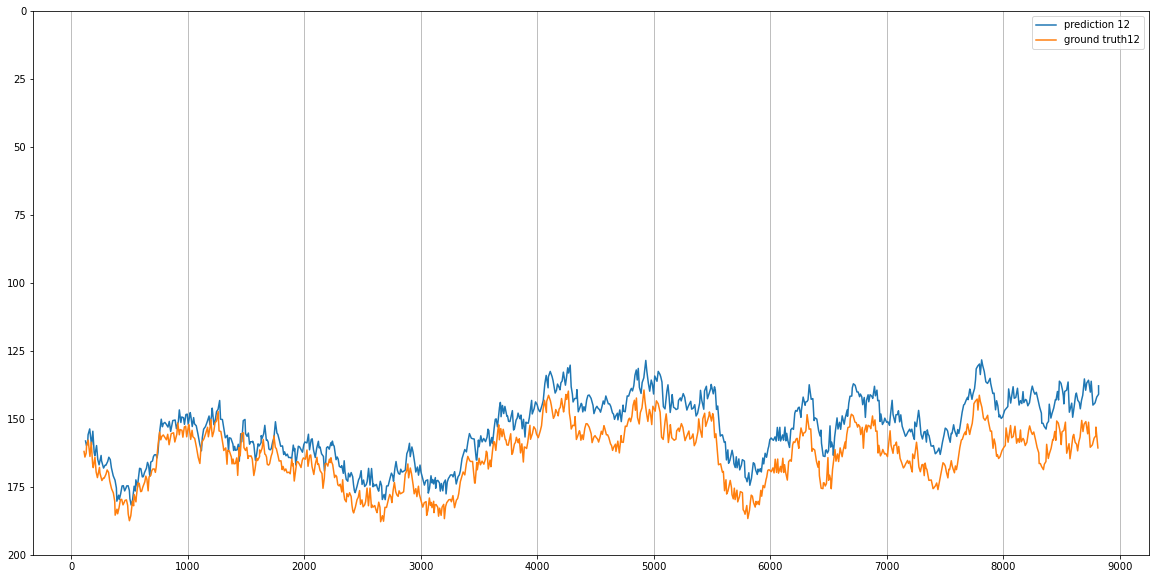

In [68]:
plot_prediction(data, pred_test_2_df, ids=[test_2_ids[-1]])

## Experiment 7: train on 5 particles (top, centre, bottom) and predict the other 10 (in two sets of 5)

In [69]:
ids = list(range(0, no_skyrmions))

top_ids = data[data['frame'] == 0].nsmallest(5, 'y')['particle'].tolist()
bottom_ids = data[data['frame'] == 0].nlargest(5, 'y')['particle'].tolist()
centre_ids = [x for x in ids if x not in top_ids and x not in bottom_ids]

top_ids.sort()
bottom_ids.sort()
centre_ids.sort()

top_data = data[data['particle'].isin(top_ids)]
centre_data = data[data['particle'].isin(centre_ids)]
bottom_data = data[data['particle'].isin(bottom_ids)]

**Top data**


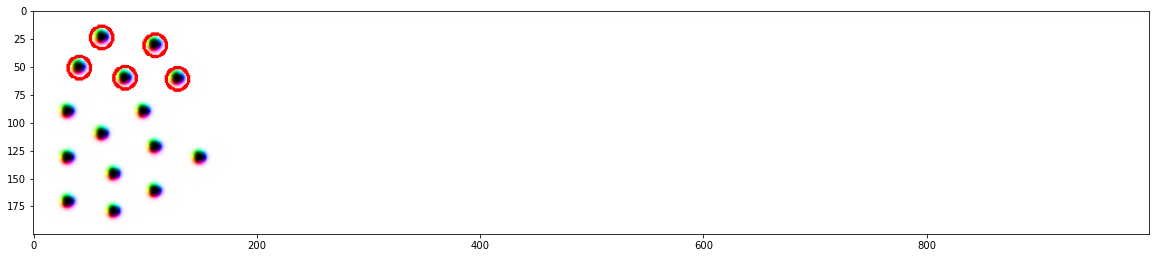

**Centre data**


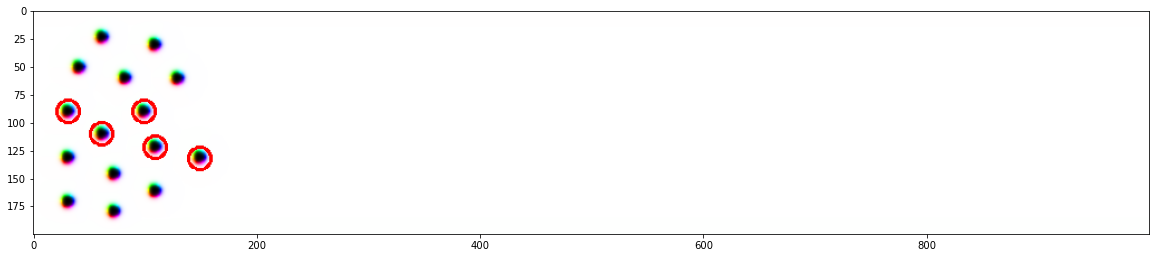

**Bottom data**


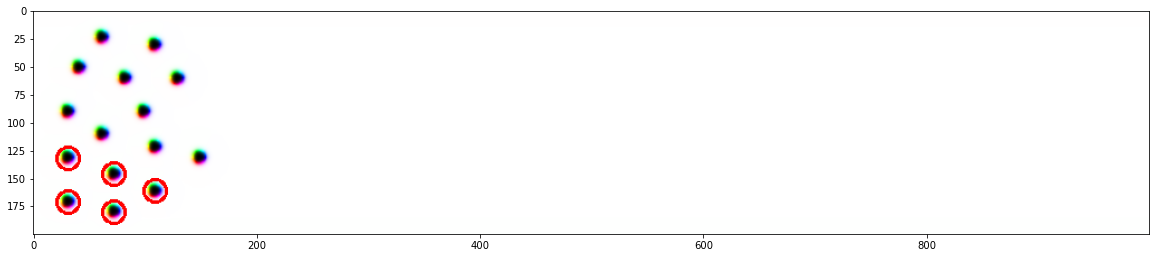

In [70]:
print('**Top data**')
show_tracked(top_data, directory)
print('**Centre data**')
show_tracked(centre_data, directory)
print('**Bottom data**')
show_tracked(bottom_data, directory)

In [71]:
top_frames = get_frames(top_data)
centre_frames = get_frames(centre_data)
bottom_frames = get_frames(bottom_data)

X_top, y_top = frames_to_xy(top_frames)
X_centre, y_centre = frames_to_xy(centre_frames)
X_bottom, y_bottom = frames_to_xy(bottom_frames)

Getting frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:02<00:00, 341.04it/s]


**Train on top**

In [72]:
lin_model = LinearRegression()
lin_model.fit(X_top, y_top)

print("The model performance for training set (top)")
top_pred = evaluate(X_top, y_top, lin_model)

print("The model performance for testing set (centre)")
centre_pred = evaluate(X_centre, y_centre, lin_model)

print("The model performance for testing set (bottom)")
bottom_pred = evaluate(X_bottom, y_bottom, lin_model)

The model performance for training set (top)
--------------------------------------
RMSE is 3.5384109586777526
R2 score is 0.9879133046376237


The model performance for testing set (centre)
--------------------------------------
RMSE is 8.366081179129846
R2 score is 0.9525343555656185


The model performance for testing set (bottom)
--------------------------------------
RMSE is 8.480387930207186
R2 score is 0.9032439896627167




In [73]:
pred_top_df = get_predictions_df(top_pred, top_ids)
pred_centre_df = get_predictions_df(centre_pred, centre_ids)
pred_bottom_df = get_predictions_df(bottom_pred, bottom_ids)

Prediction to dataframe: 100%|████████████████████████████████████████████████████████████████████████████████████| 799/799 [00:04<00:00, 177.28it/s]


In [74]:
print(f'Top ids: {top_ids}')

Top ids: [0.0, 1.0, 2.0, 3.0, 4.0]


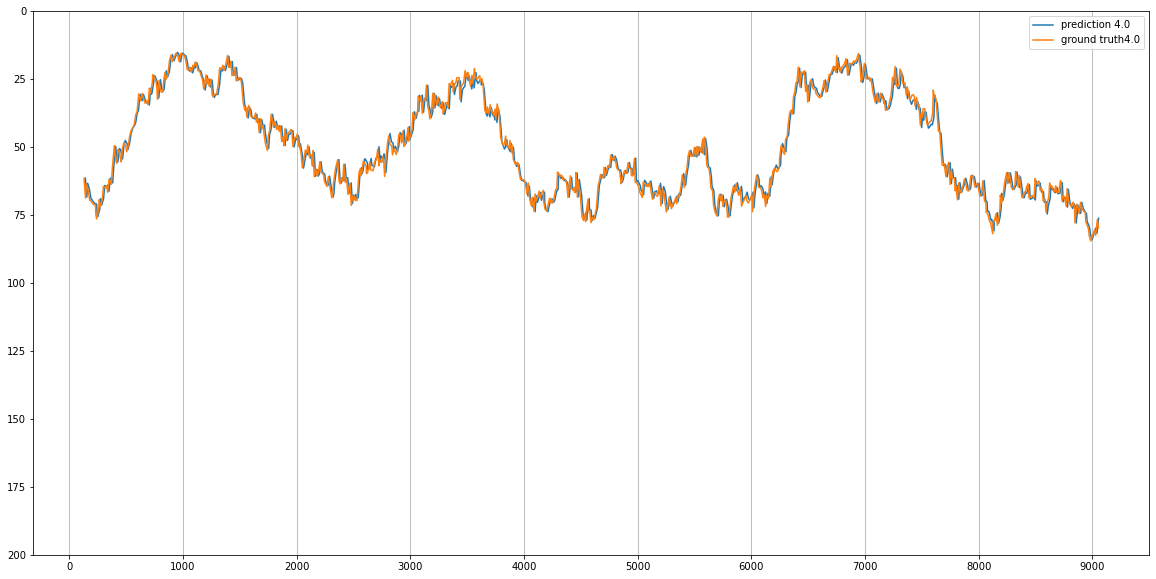

In [75]:
plot_prediction(data, pred_top_df, ids=[top_ids[-1]])

In [76]:
print(f'Centre ids: {centre_ids}')

Centre ids: [5, 6, 7, 8, 10]


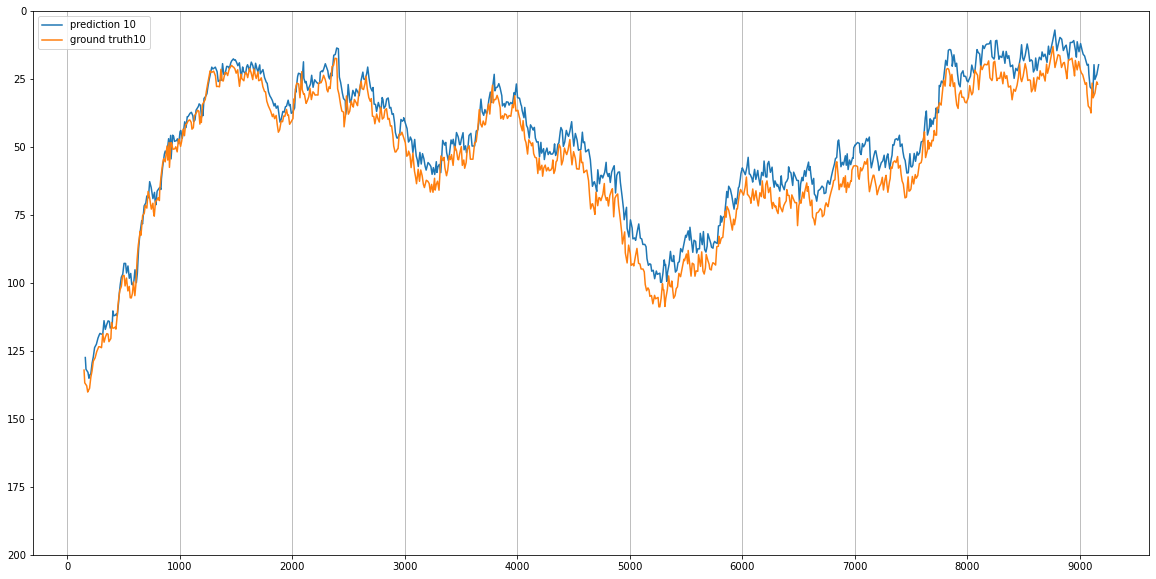

In [77]:
plot_prediction(data, pred_centre_df, ids=[centre_ids[-1]])

In [78]:
print(f'Bottom ids: {bottom_ids}')

Bottom ids: [9.0, 11.0, 12.0, 13.0, 14.0]


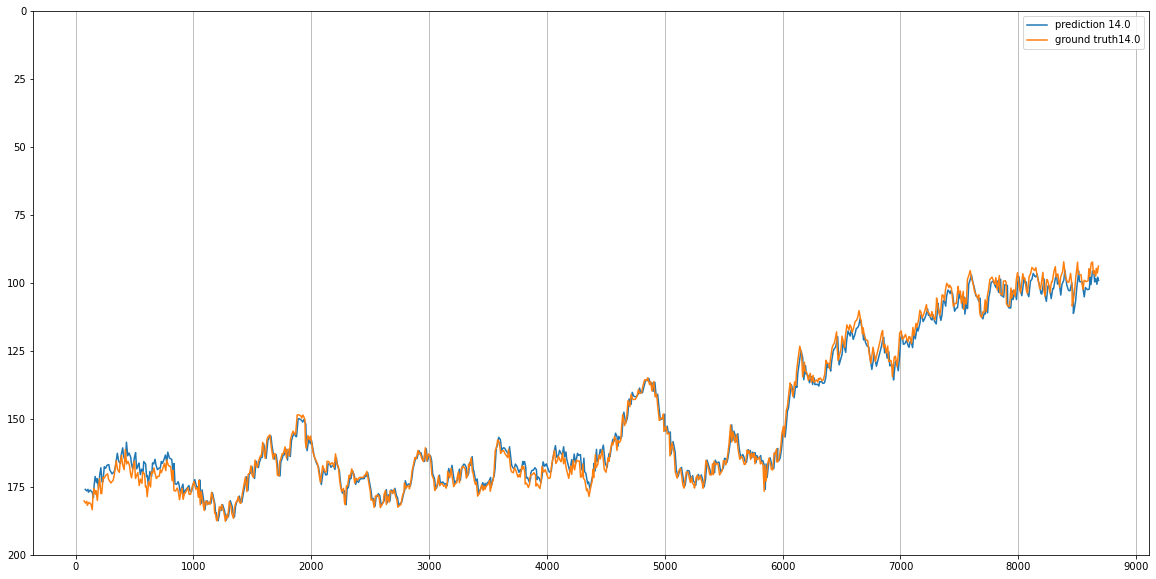

In [79]:
plot_prediction(data, pred_bottom_df, ids=[bottom_ids[-1]])

**Train on centre**

In [80]:
lin_model = LinearRegression()
lin_model.fit(X_centre, y_centre)

print("The model performance for training set (centre)")
centre_pred = evaluate(X_centre, y_centre, lin_model)

print("The model performance for testing set (top)")
top_pred = evaluate(X_top, y_top, lin_model)

print("The model performance for testing set (bottom)")
bottom_pred = evaluate(X_bottom, y_bottom, lin_model)

The model performance for training set (centre)
--------------------------------------
RMSE is 3.6086960518466973
R2 score is 0.9915238403916924


The model performance for testing set (top)
--------------------------------------
RMSE is 11.761901504967417
R2 score is 0.8922935750143237


The model performance for testing set (bottom)
--------------------------------------
RMSE is 11.146758236691348
R2 score is 0.9305108391187005




In [81]:
pred_top_df = get_predictions_df(top_pred, top_ids)
pred_centre_df = get_predictions_df(centre_pred, centre_ids)
pred_bottom_df = get_predictions_df(bottom_pred, bottom_ids)

Prediction to dataframe: 100%|████████████████████████████████████████████████████████████████████████████████████| 799/799 [00:04<00:00, 174.58it/s]


In [82]:
print(f'Centre ids: {centre_ids}')

Centre ids: [5, 6, 7, 8, 10]


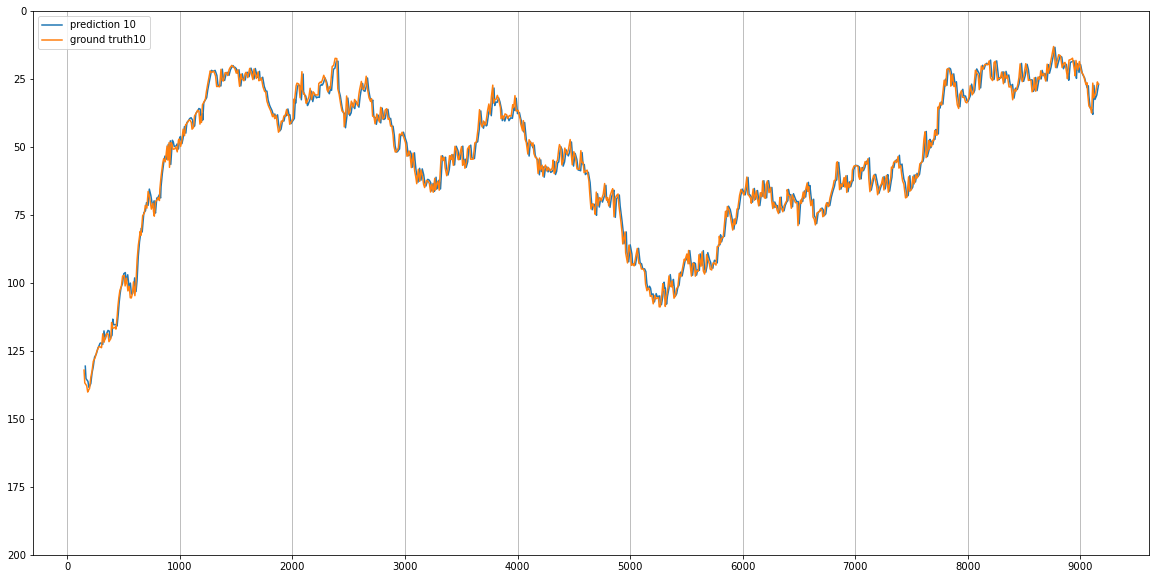

In [83]:
plot_prediction(data, pred_centre_df, ids=[centre_ids[-1]])

In [84]:
print(f'Top ids: {top_ids}')

Top ids: [0.0, 1.0, 2.0, 3.0, 4.0]


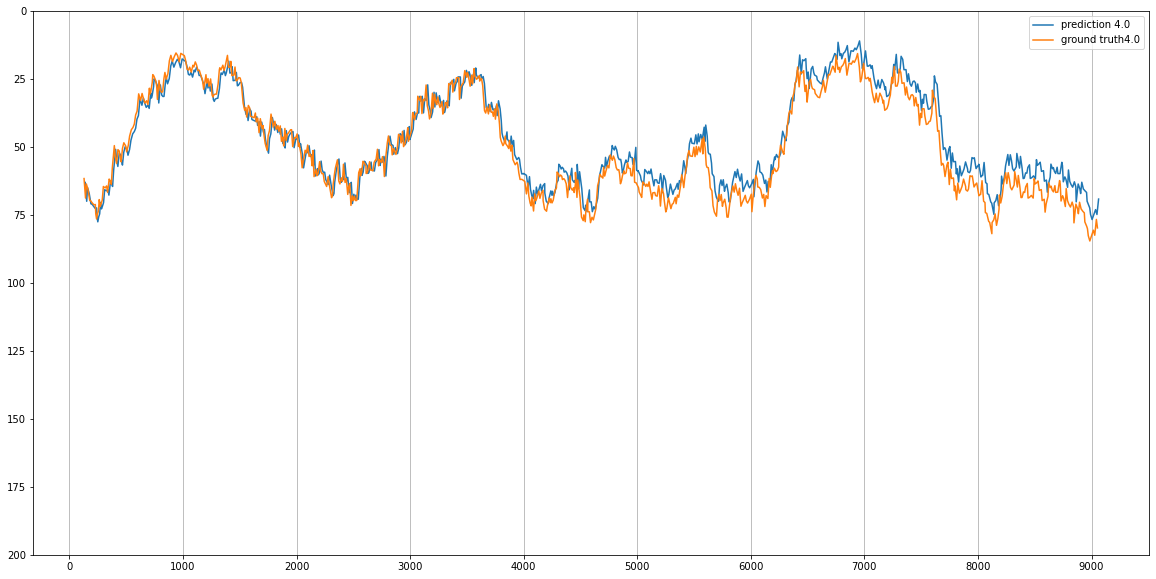

In [85]:
plot_prediction(data, pred_top_df, ids=[top_ids[-1]])

In [86]:
print(f'Bottom ids: {bottom_ids}')

Bottom ids: [9.0, 11.0, 12.0, 13.0, 14.0]


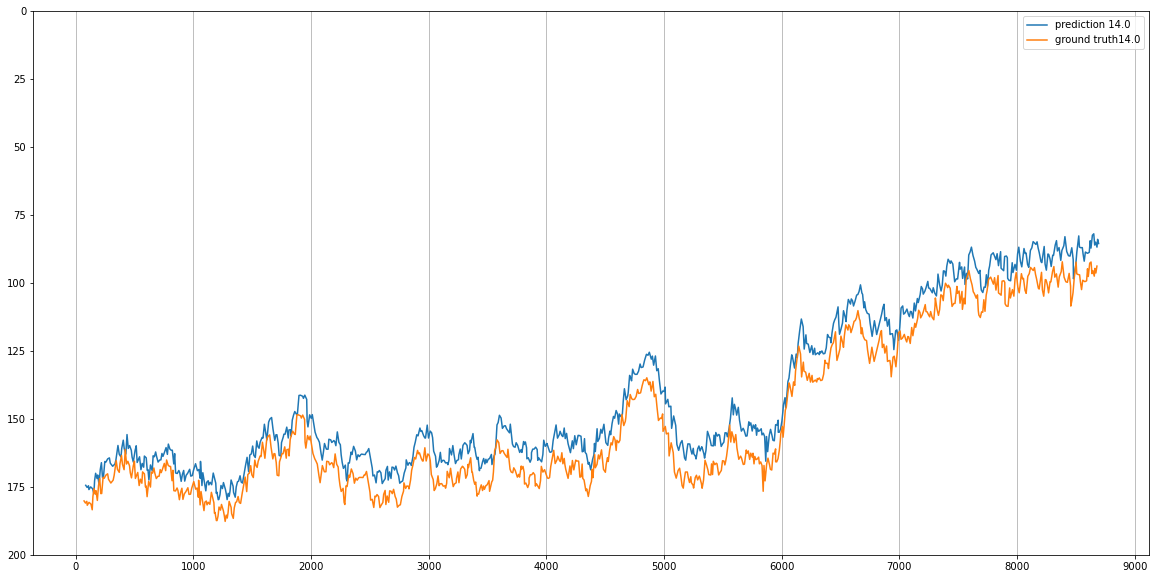

In [87]:
plot_prediction(data, pred_bottom_df, ids=[bottom_ids[-1]])

**Train on bottom**

In [88]:
lin_model = LinearRegression()
lin_model.fit(X_bottom, X_bottom)

print("The model performance for training set (bottom)")
bottom_pred = evaluate(X_bottom, y_bottom, lin_model)

print("The model performance for testing set (centre)")
centre_pred = evaluate(X_centre, y_centre, lin_model)

print("The model performance for testing set (top)")
top_pred = evaluate(X_top, y_top, lin_model)

The model performance for training set (bottom)
--------------------------------------
RMSE is 8.473243898917952
R2 score is 0.9814422797040983


The model performance for testing set (centre)
--------------------------------------
RMSE is 8.626416563199392
R2 score is 0.9911342251604113


The model performance for testing set (top)
--------------------------------------
RMSE is 8.637986630862377
R2 score is 0.9873691487229118




In [89]:
pred_top_df = get_predictions_df(top_pred, top_ids)
pred_centre_df = get_predictions_df(centre_pred, centre_ids)
pred_bottom_df = get_predictions_df(bottom_pred, bottom_ids)

Prediction to dataframe: 100%|████████████████████████████████████████████████████████████████████████████████████| 799/799 [00:04<00:00, 175.92it/s]


In [90]:
print(f'Bottom ids: {bottom_ids}')

Bottom ids: [9.0, 11.0, 12.0, 13.0, 14.0]


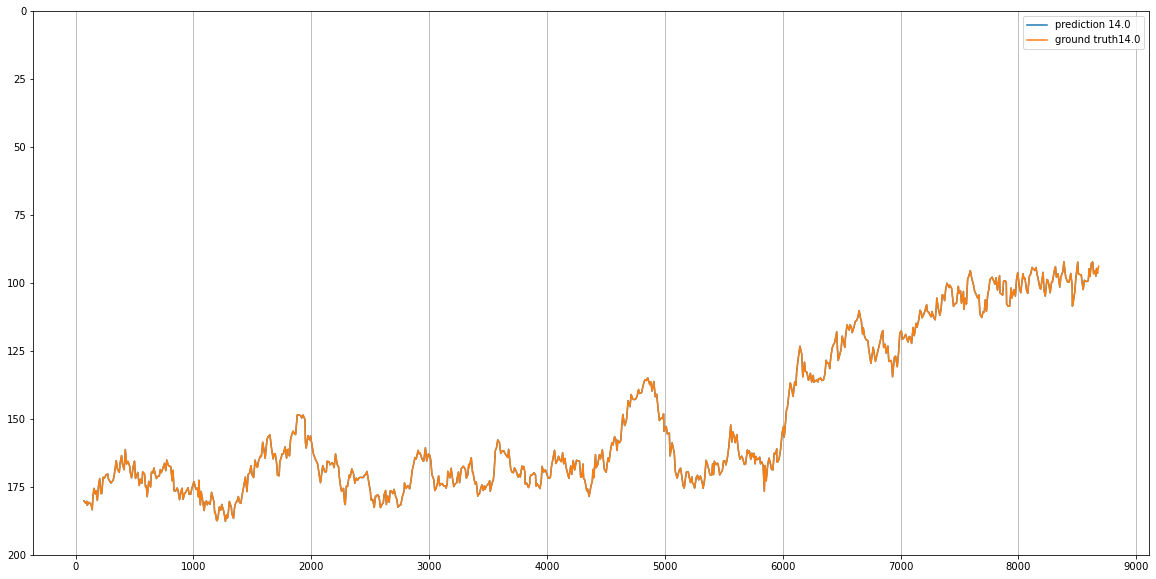

In [91]:
plot_prediction(data, pred_bottom_df, ids=[bottom_ids[-1]])

In [92]:
print(f'Centre ids: {centre_ids}')

Centre ids: [5, 6, 7, 8, 10]


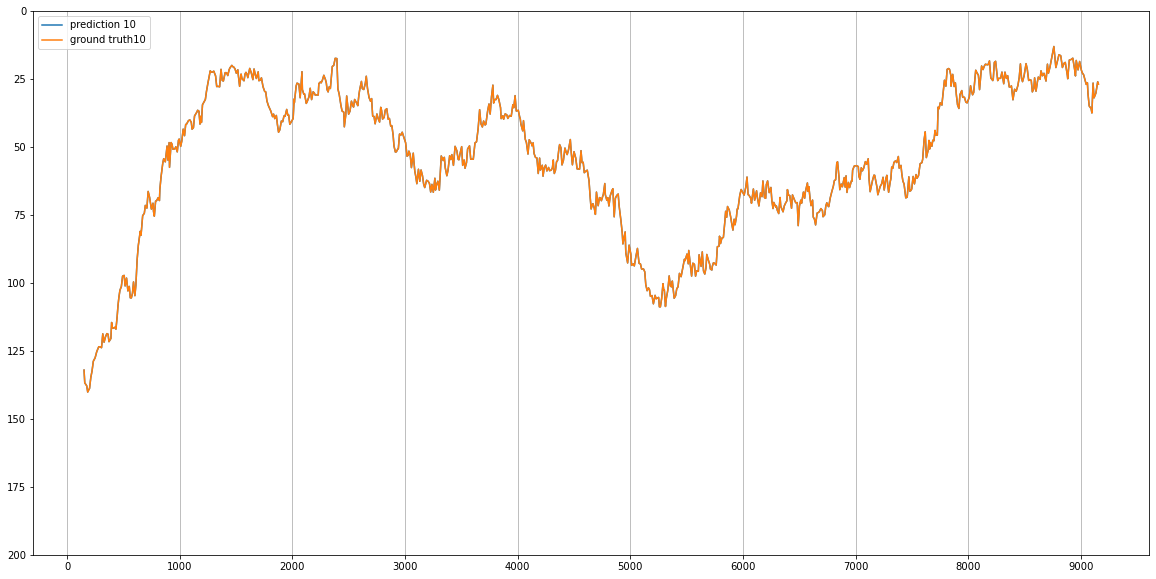

In [93]:
plot_prediction(data, pred_centre_df, ids=[centre_ids[-1]])

In [94]:
print(f'Top ids: {top_ids}')

Top ids: [0.0, 1.0, 2.0, 3.0, 4.0]


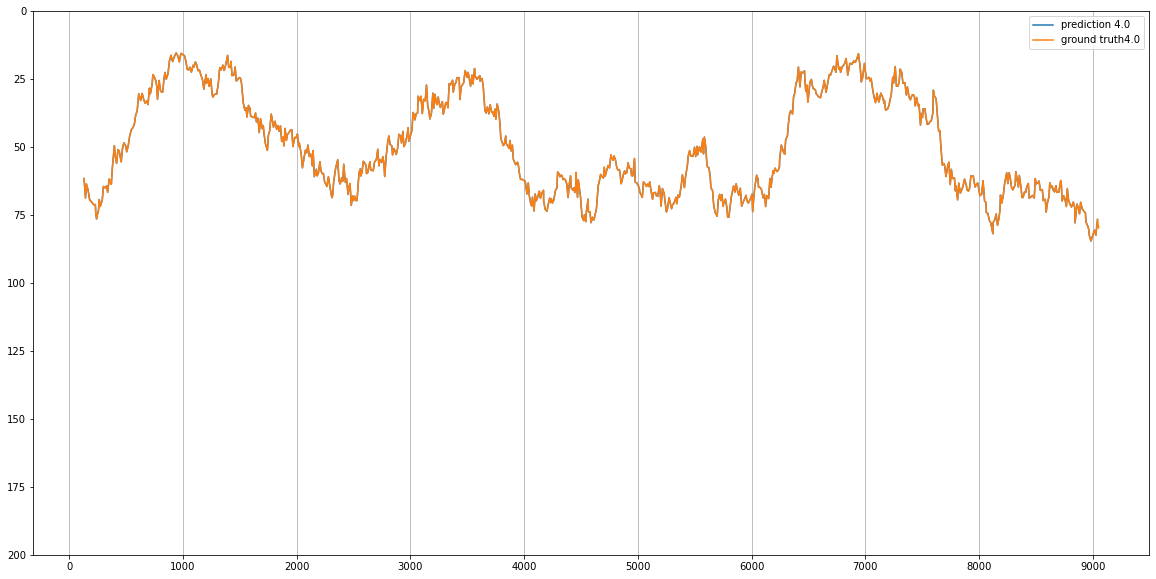

In [95]:
plot_prediction(data, pred_top_df, ids=[top_ids[-1]])